# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil as st
import math
import seaborn as sns

from opendata import OpenData
from opendata.models import LocalAthlete
from lmfit import minimize, Parameters
from dateutil.parser import parse
import datetime
from tqdm import tqdm
from IPython.display import display
from statistics import mean

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

/Users/mateuszbulanda-gorol/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)

In [3]:
od = OpenData()

In [4]:
athletes = list(od.remote_athletes())

In [5]:
len(athletes)

6613

In [6]:
random_athlete = athletes[448]

In [7]:
random_athlete.metadata['ATHLETE']

{'gender': 'M', 'yob': '1979', 'id': '{11bf3ef3-c7b3-4d8d-be36-9021982b51f3}'}

In [8]:
random_athlete.id

'11bf3ef3-c7b3-4d8d-be36-9021982b51f3'

In [9]:
random_activities = list(random_athlete.activities())

In [10]:
len(random_activities)

243

## Choosing random activity

In [11]:
n = 154

In [12]:
random_activities[n].metadata

{'date': '2018/11/05 15:26:21 UTC',
 'data': 'TDSPHC-AGL-----',
 'sport': 'Bike',
 'METRICS': {'a_skiba_xpower': ['198.90497', '3131.00000'],
  'a_skiba_relative_intensity': ['0.84640', '3131.00000'],
  'a_skiba_bike_score': '62.30690',
  'a_skiba_variability_index': '1.18095',
  'a_skiba_response_index': '1.47541',
  'a_coggan_np': ['206.86499', '3131.00000'],
  'a_coggan_if': ['0.88028', '3131.00000'],
  'a_coggan_tss': '67.39363',
  'a_coggam_variability_index': ['1.22821', '3131.00000'],
  'a_friel_efficiency_factor': '1.53446',
  'a_coggan_tssperhour': ['77.48868', '0.86972'],
  'aerobic_decoupling': '11.65664',
  'power_index': ['63.33773', '1.00000'],
  'ride_count': '1.00000',
  'workout_time': '3131.00000',
  'time_riding': '3124.00000',
  'total_distance': '28.80733',
  'climb_rating': ['0.17302', '1.00000'],
  'athlete_weight': '80.00000',
  'elevation_gain': '70.60000',
  'elevation_loss': '84.20000',
  'total_work': '527.35000',
  'average_speed': '33.19667',
  'average_po

In [13]:
len(random_activities[n].metadata['METRICS']['power_mmp'])

326

In [14]:
i = 0
for sec in random_activities[n].metadata['METRICS']['power_mmp_secs']:
    if (sec == 1200):
        print(i)
        break
    i = i + 1

283


In [15]:
print(random_activities[n].metadata['METRICS']['power_mmp_secs'][:284])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 39

### Because 1200 seconds is 20 minutes and this is perfect time to estimate FTP

## Plotting power curve of the activity

<AxesSubplot:xlabel='duration', ylabel='power'>

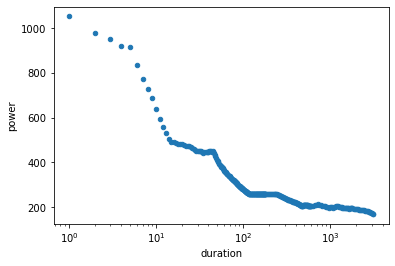

In [16]:
df = pd.DataFrame({'duration':random_activities[n].metadata['METRICS']['power_mmp_secs'], 'power':random_activities[n].metadata['METRICS']['power_mmp']})
df.plot('duration', 'power', kind='scatter', logx=True)

In [17]:
random_activities[n].data[:20]

secs       km  power  hr  cad  alt
0      0  0.00000     59  80   71  9.6
1      1  0.00205     59  81   75  9.6
2      2  0.00462     59  82   77  9.6
3      3  0.00765     59  83   78  9.4
4      4  0.01111     59  83   78  9.4
5      5  0.01501     59  84   80  9.2
6      6  0.01925     59  85   80  9.2
7      7  0.02387     59  85   82  9.0
8      8  0.02883     59  85   83  8.8
9      9  0.03411     58  85   83  8.8
10    10  0.03971     59  85   83  8.6
11    11  0.04559     58  84   82  8.4
12    12  0.05182     59  84   82  8.2
13    13  0.05834     59  84   82  8.0
14    14  0.06511     58  85   83  7.8
15    15  0.07217     58  85   85  7.6
16    16  0.07954     59  86   84  7.2
17    17  0.08719     62  86   85  7.0
18    18  0.09513     62  87   85  6.6
19    19  0.10315     63  87   85  6.4

## Plotting power duration of the activity

<AxesSubplot:>

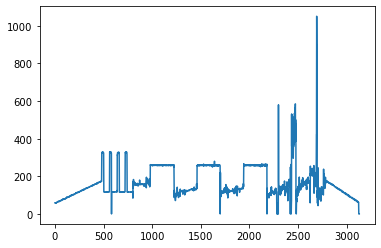

In [18]:
random_activities[n].data.power.plot()

## Plotting heart rate duration of the activity

<AxesSubplot:>

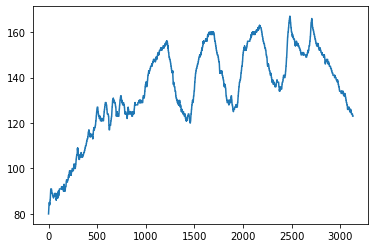

In [19]:
random_activities[n].data.hr.plot()

## Plotting altitude duration of the training

### Btw, we can see that the athlete ride the same loop twice

<AxesSubplot:>

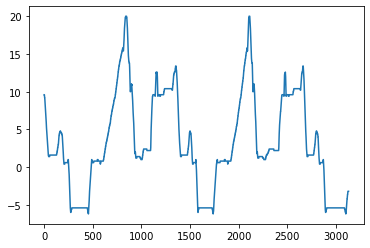

In [20]:
random_activities[n].data.alt.plot()

# Filter all activities with power data

In [21]:
bike_activities = list()
for activity in random_activities:
    if 'power_mmp_secs' in activity.metadata['METRICS']:
        bike_activities.append(activity)
len(bike_activities)

232

## Plotting power curve for every activity for chosen athlete

/Users/mateuszbulanda-gorol/opt/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


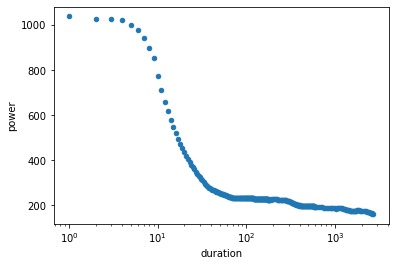

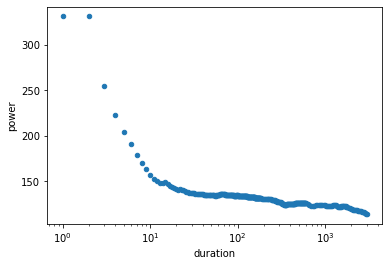

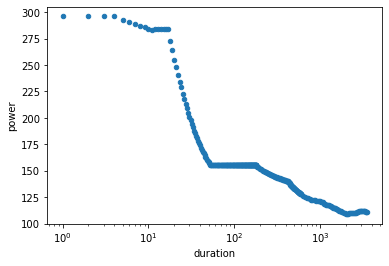

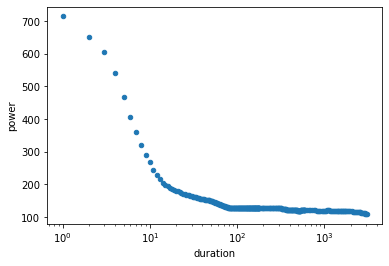

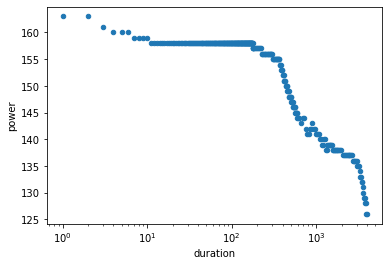

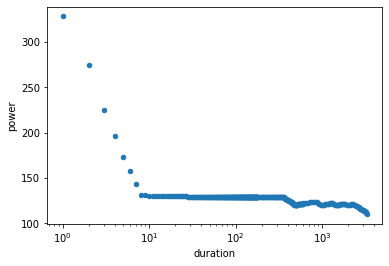

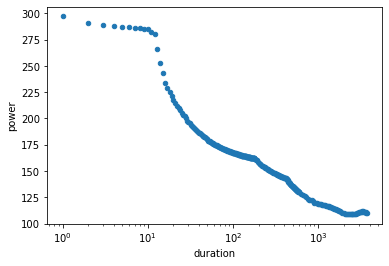

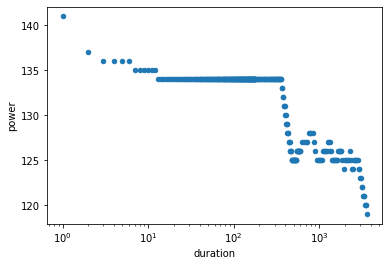

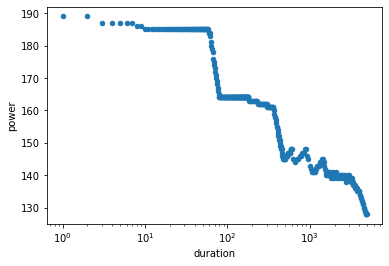

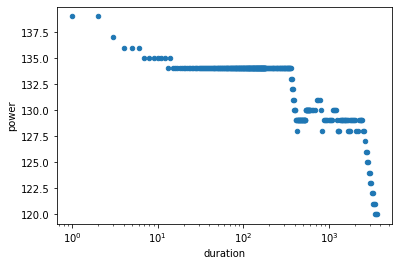

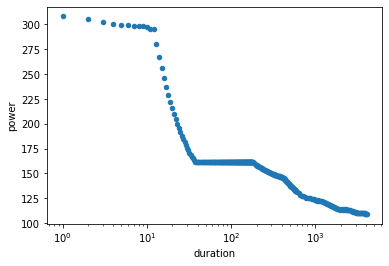

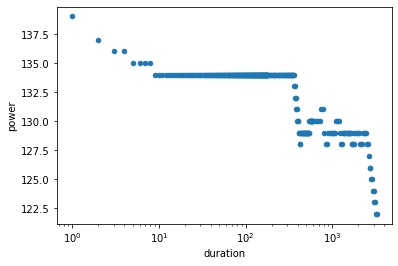

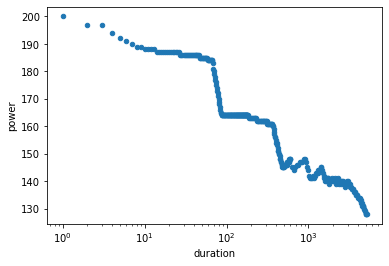

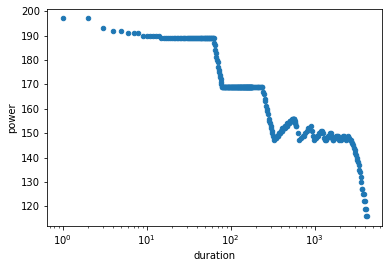

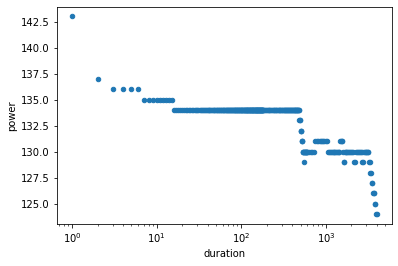

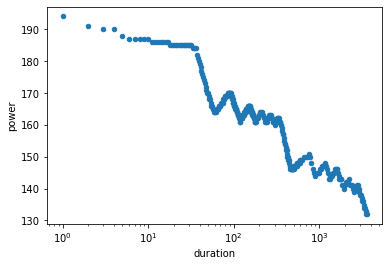

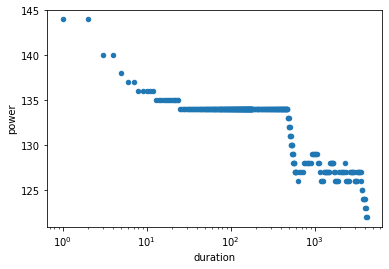

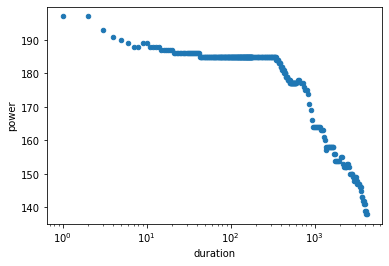

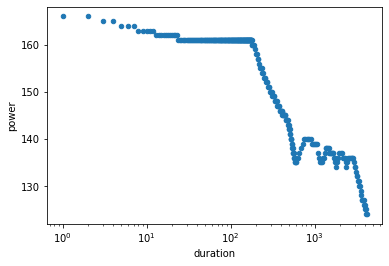

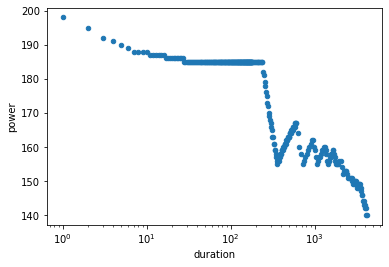

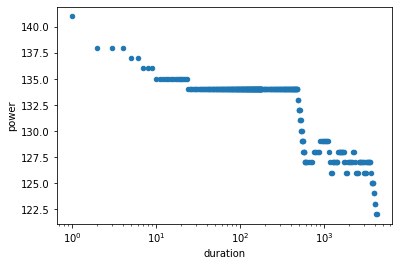

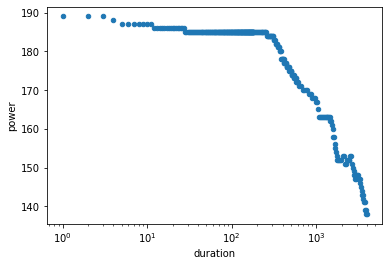

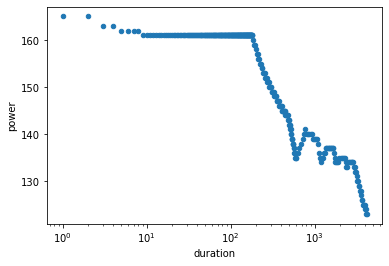

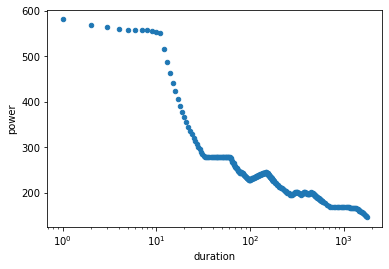

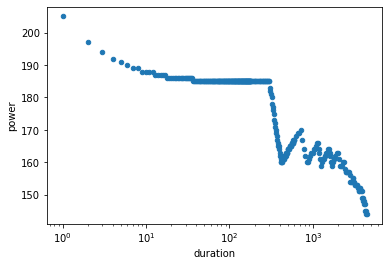

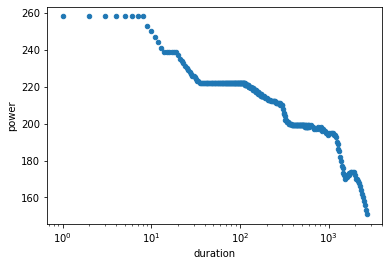

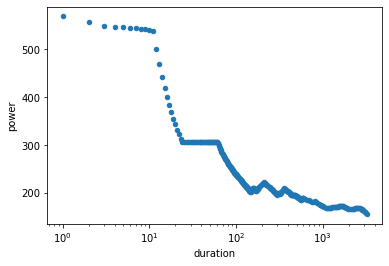

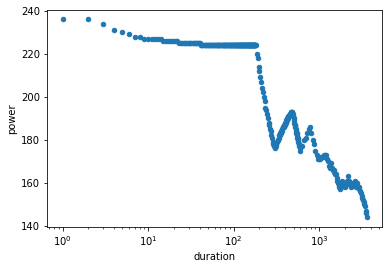

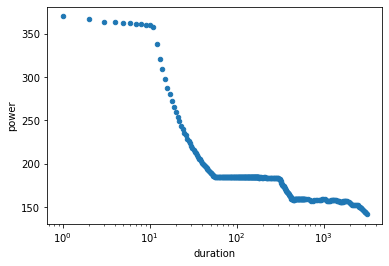

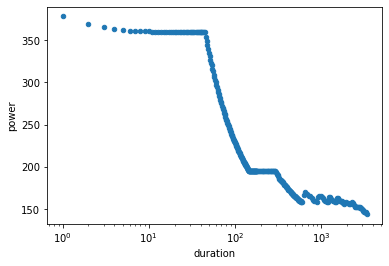

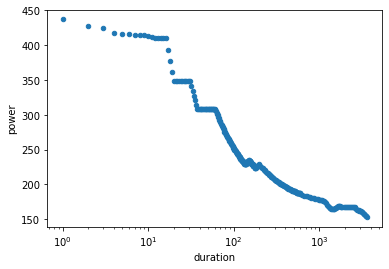

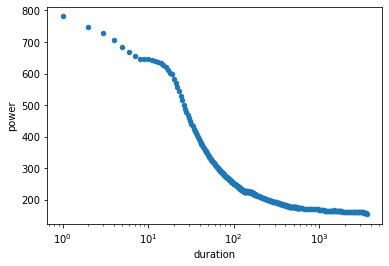

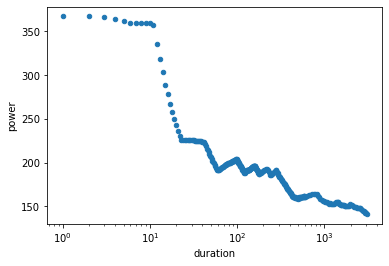

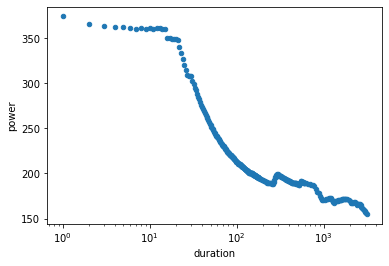

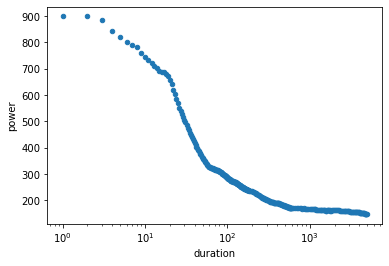

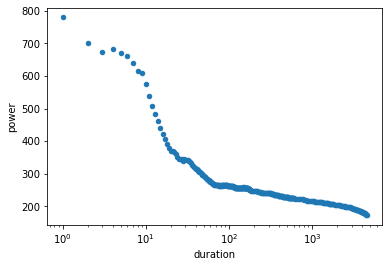

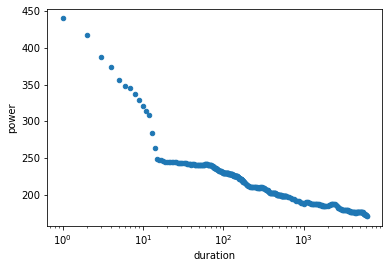

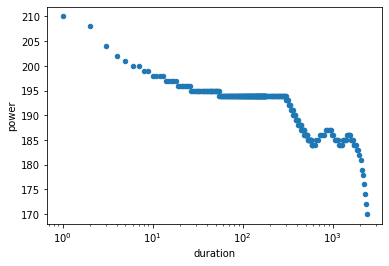

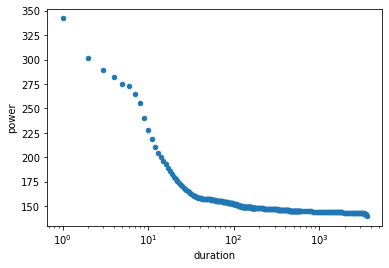

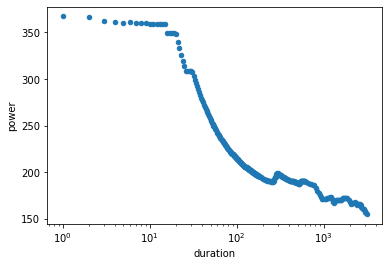

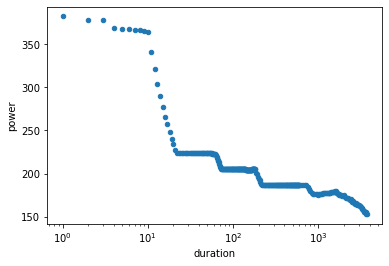

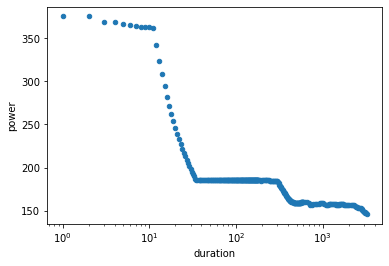

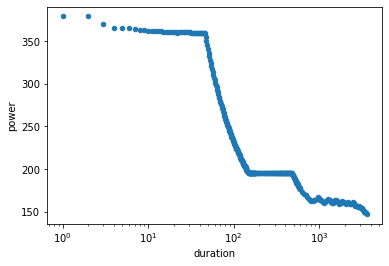

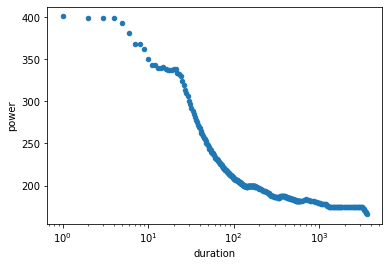

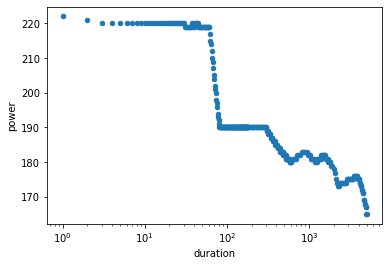

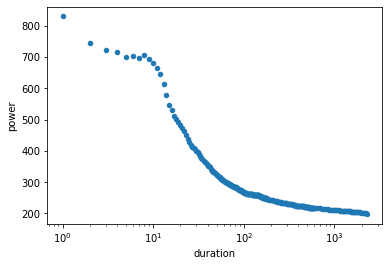

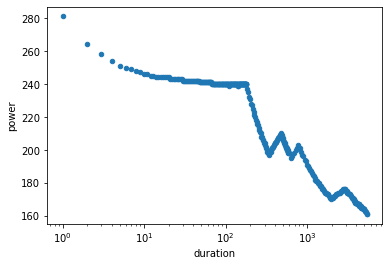

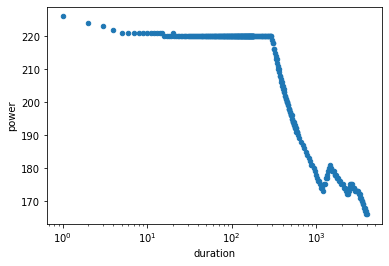

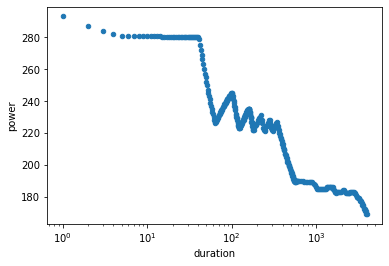

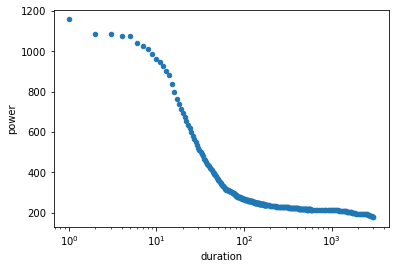

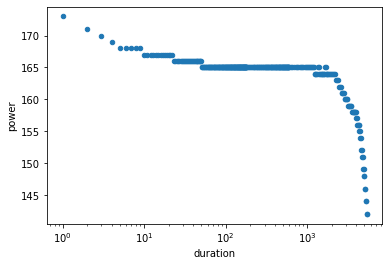

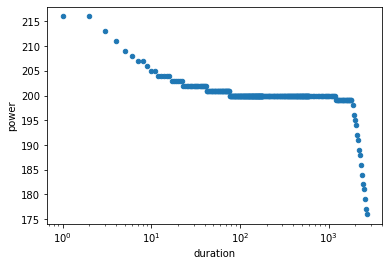

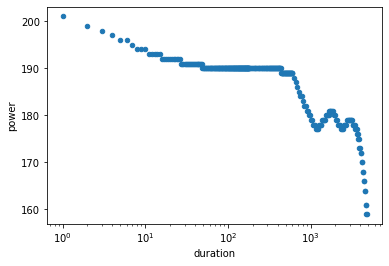

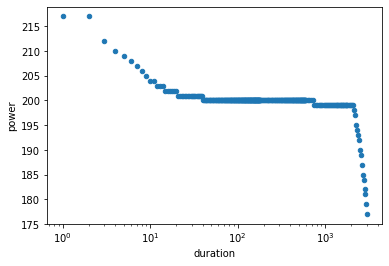

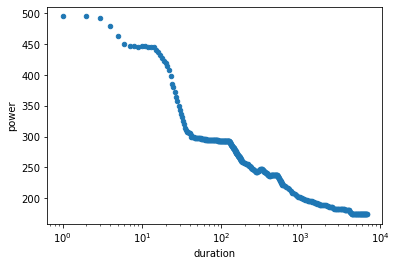

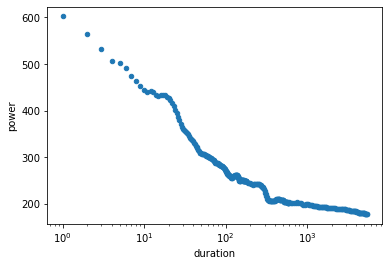

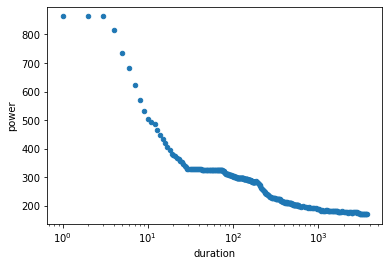

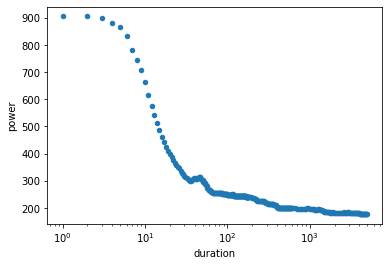

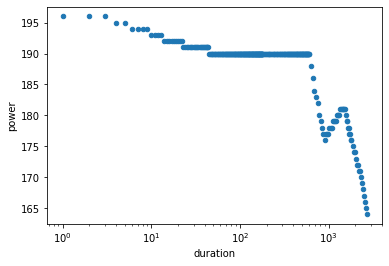

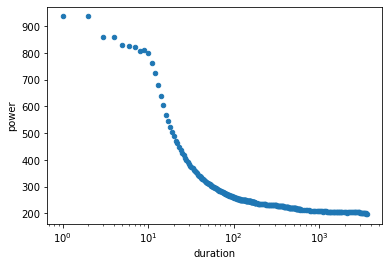

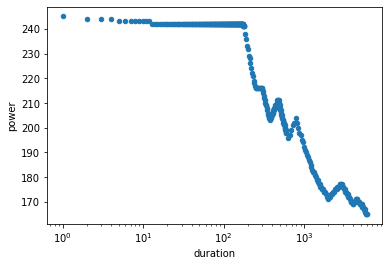

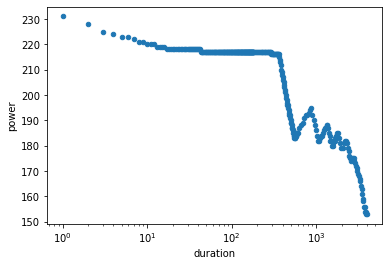

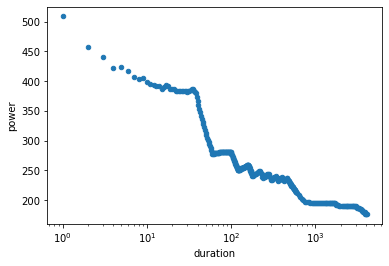

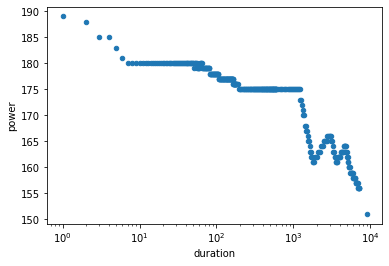

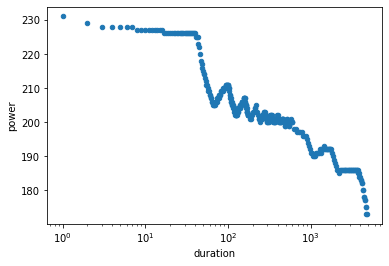

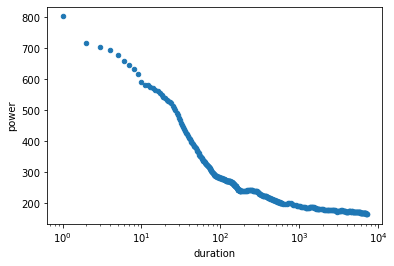

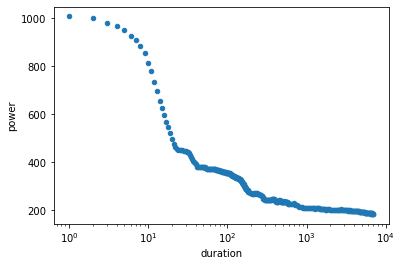

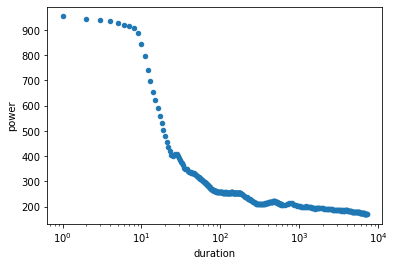

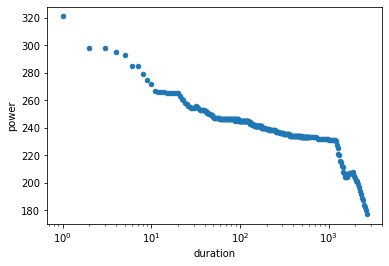

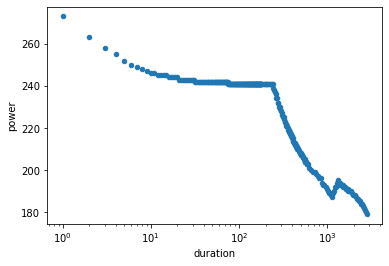

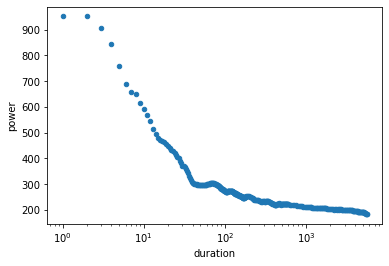

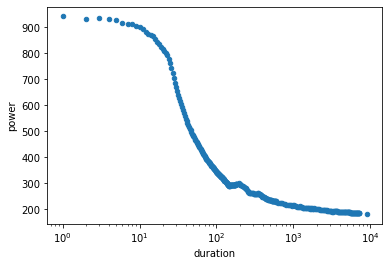

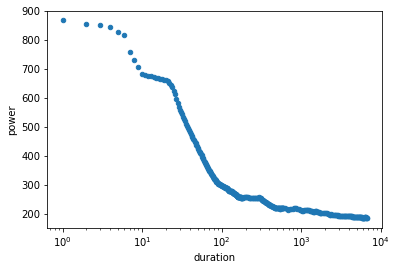

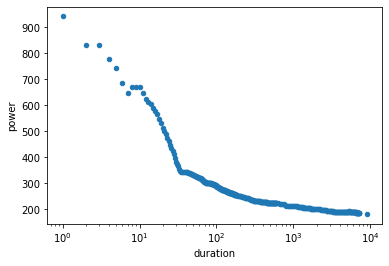

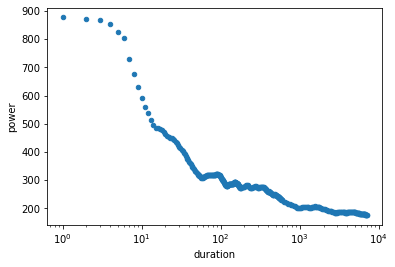

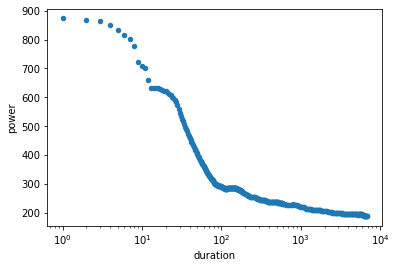

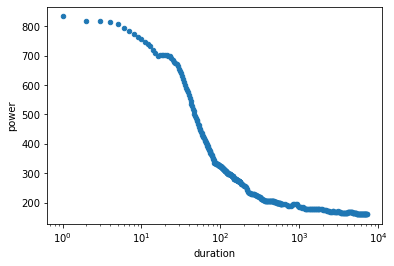

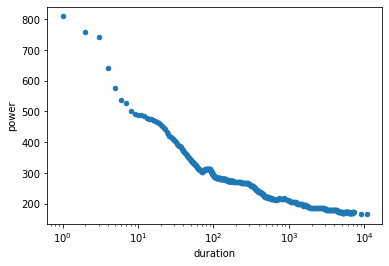

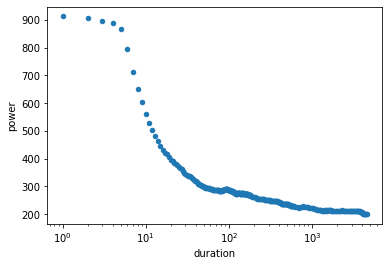

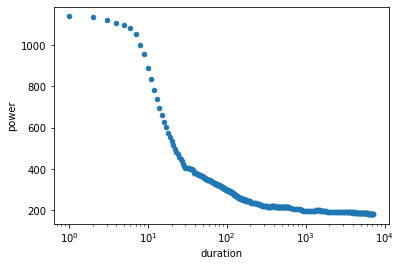

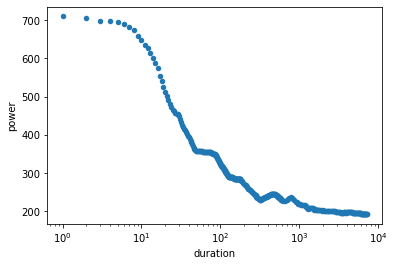

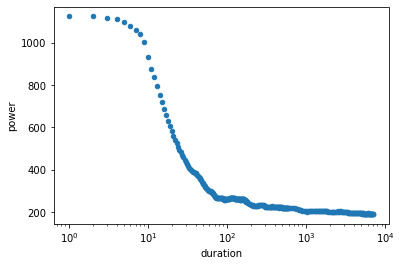

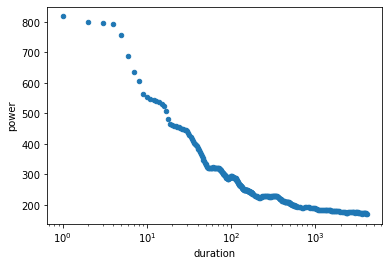

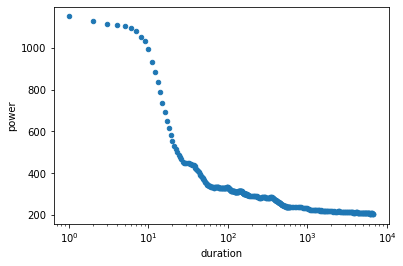

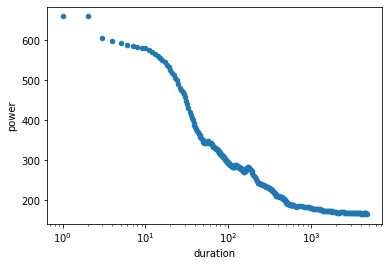

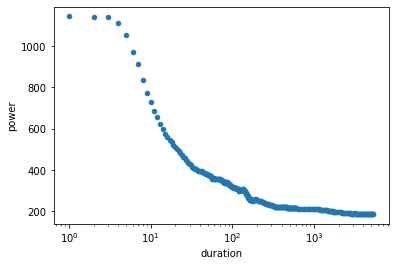

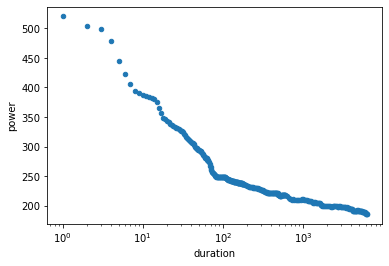

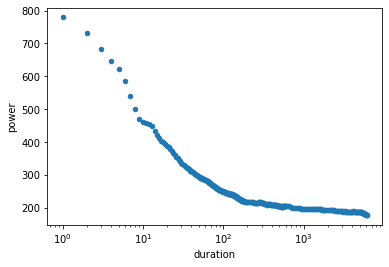

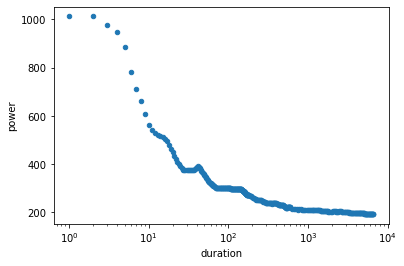

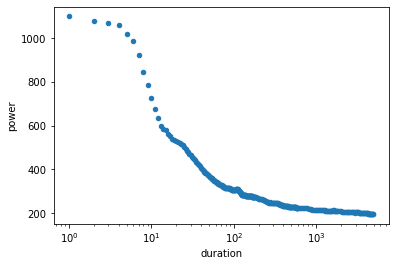

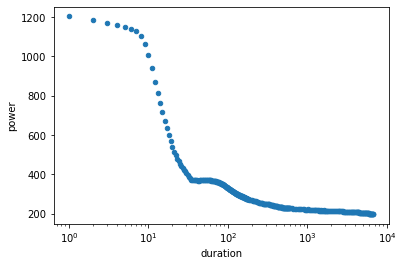

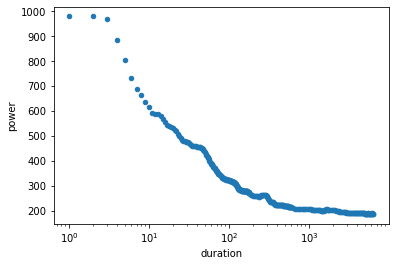

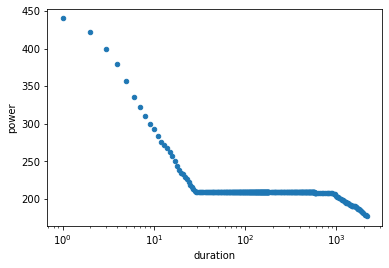

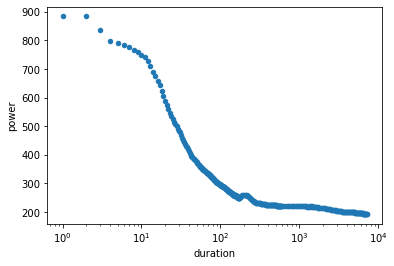

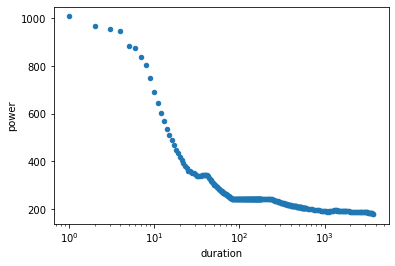

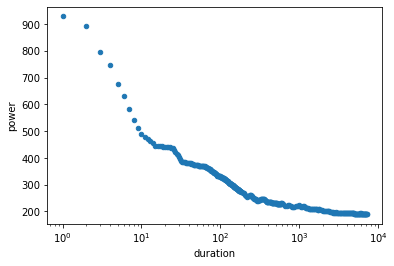

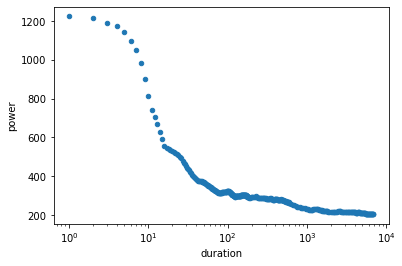

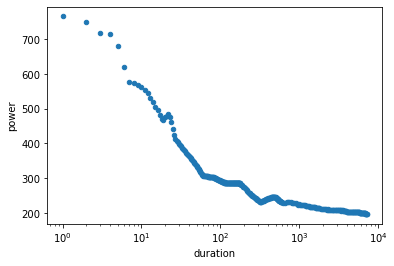

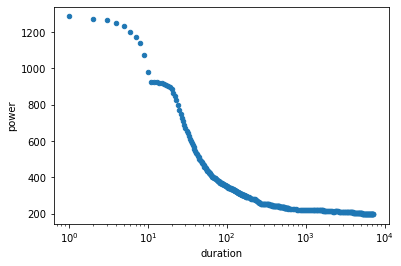

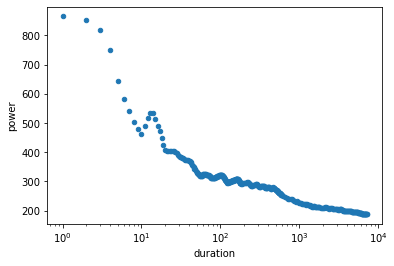

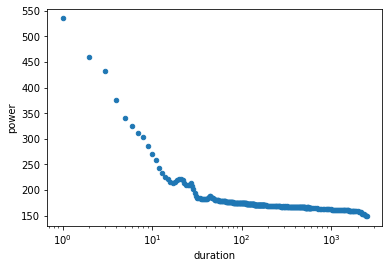

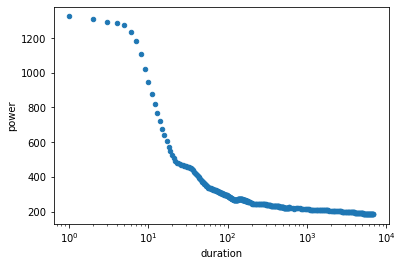

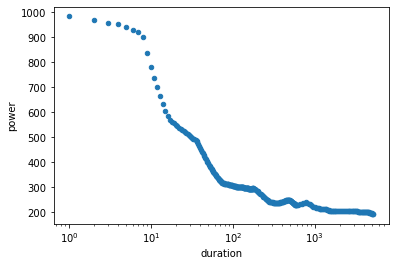

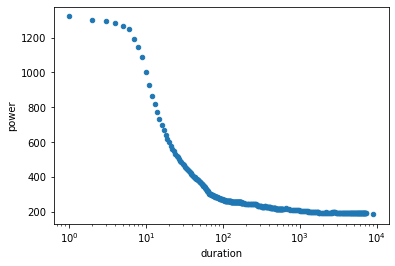

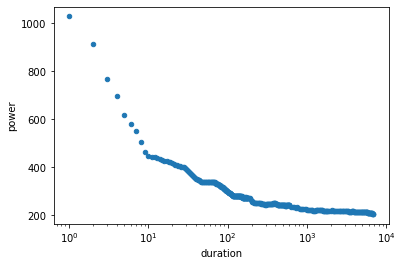

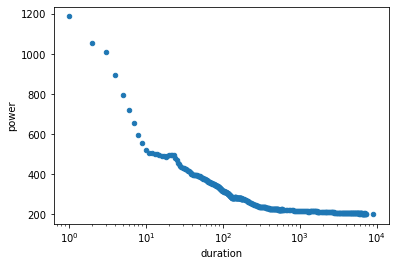

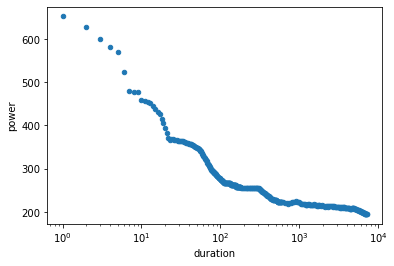

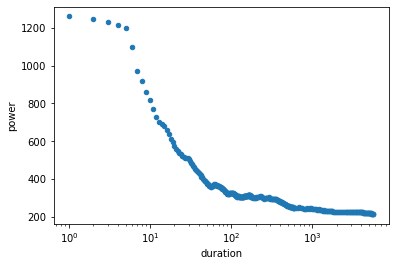

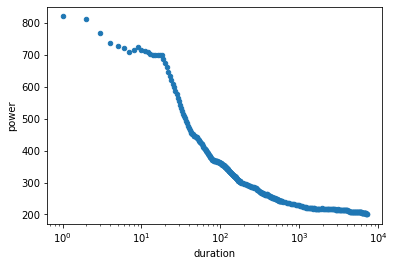

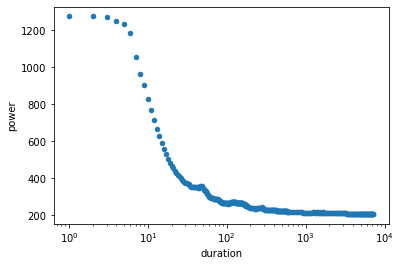

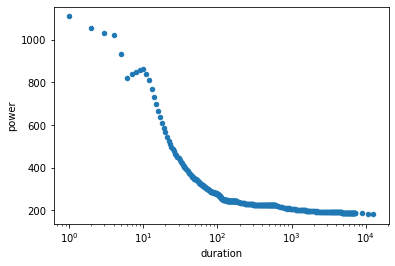

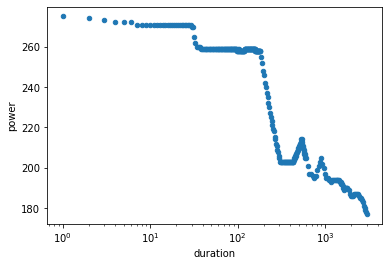

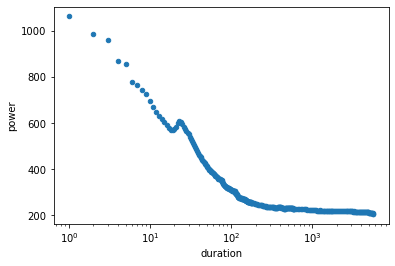

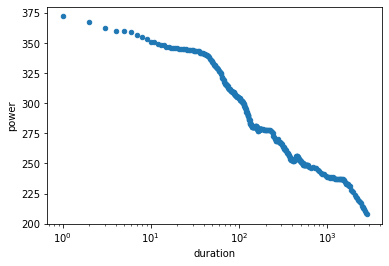

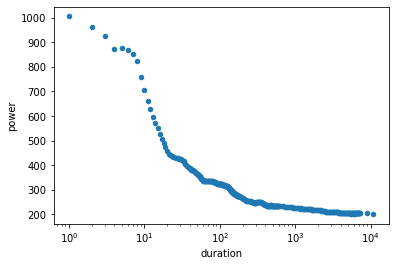

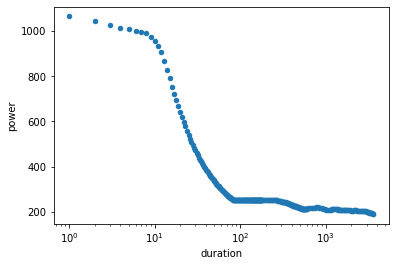

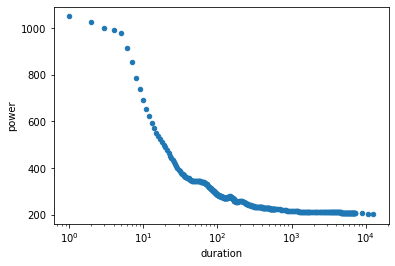

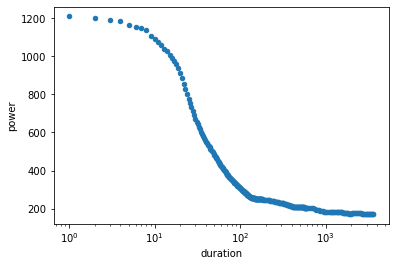

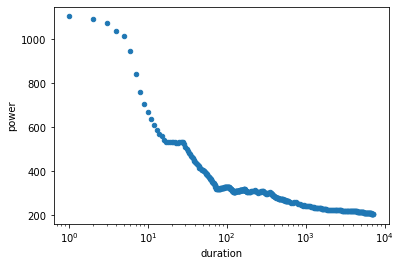

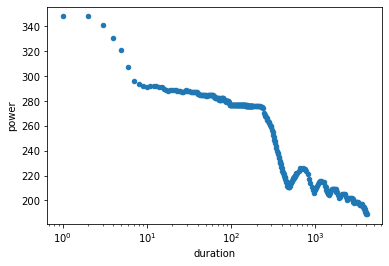

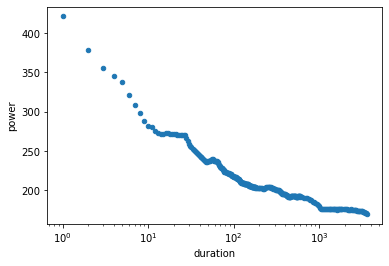

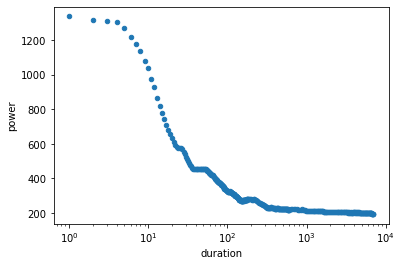

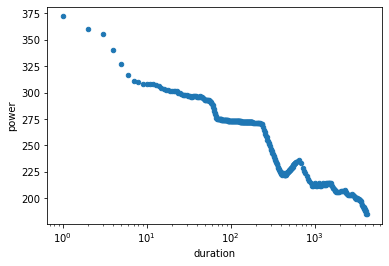

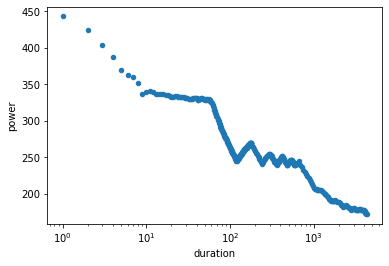

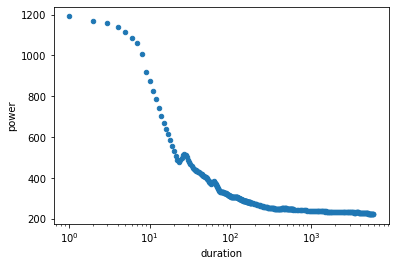

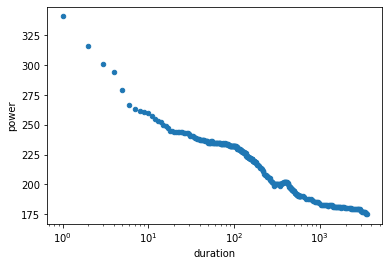

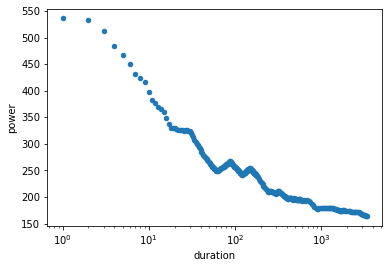

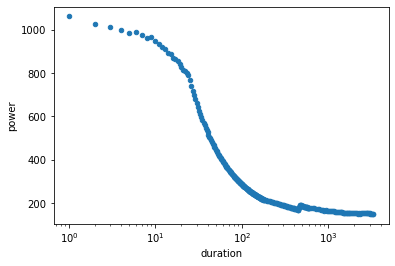

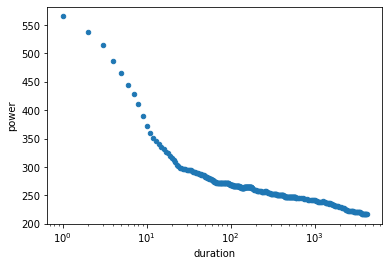

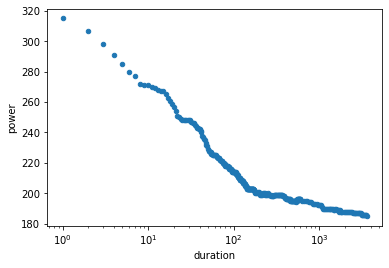

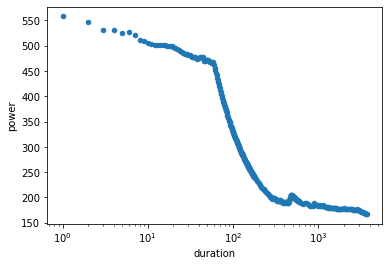

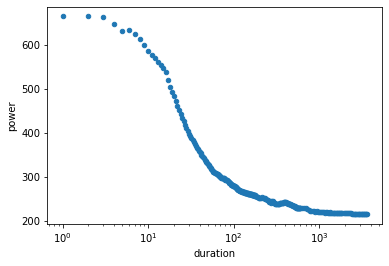

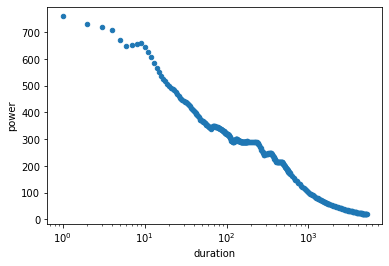

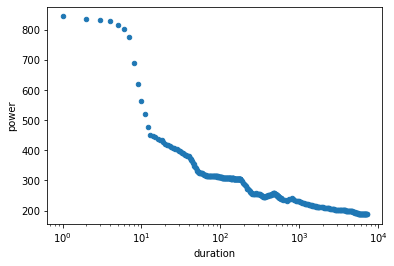

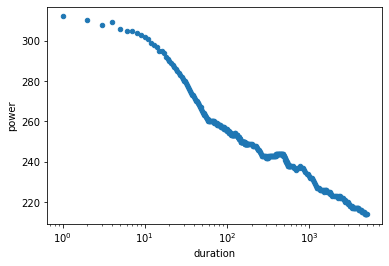

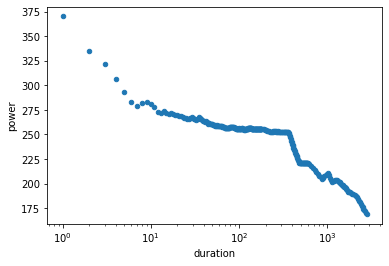

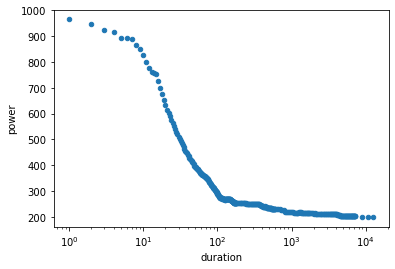

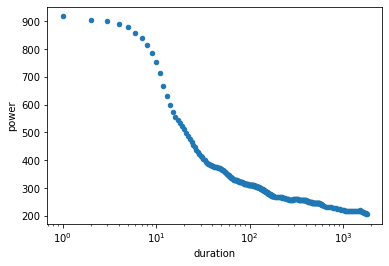

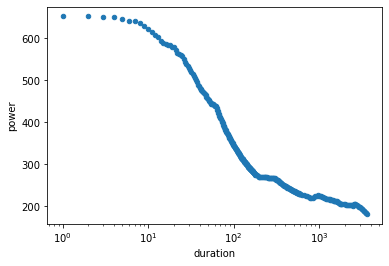

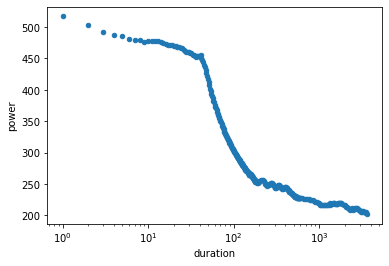

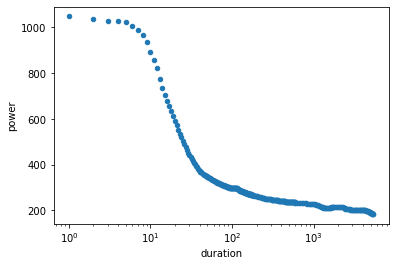

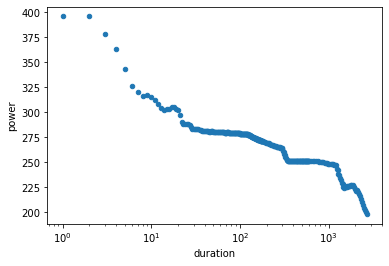

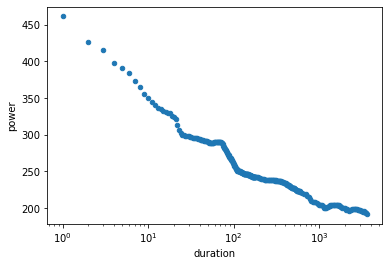

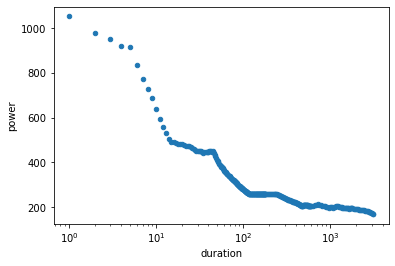

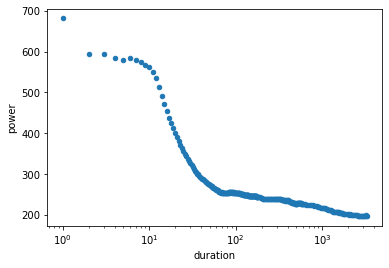

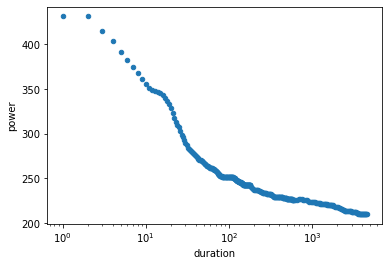

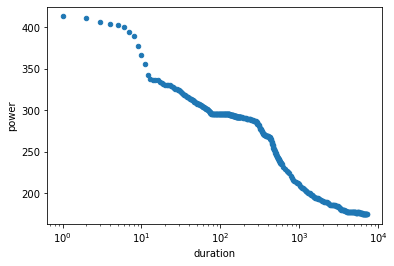

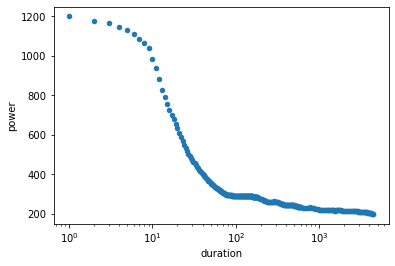

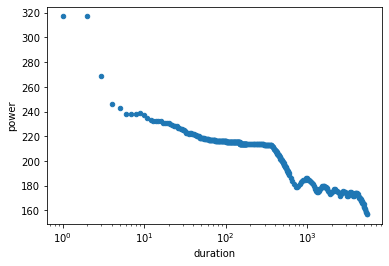

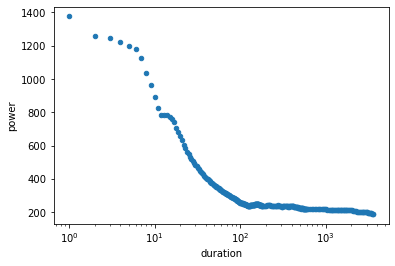

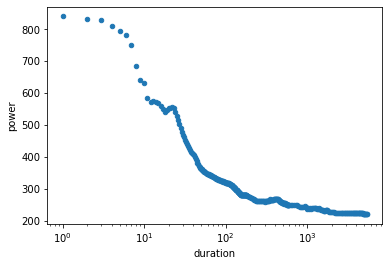

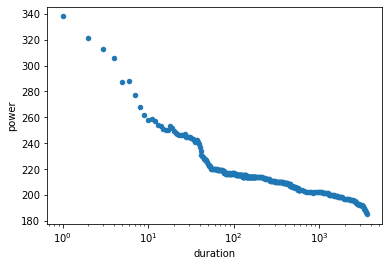

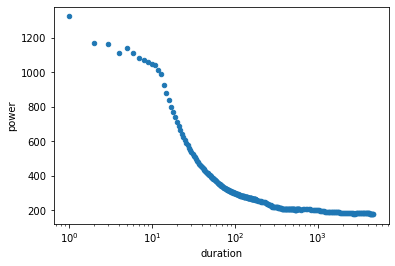

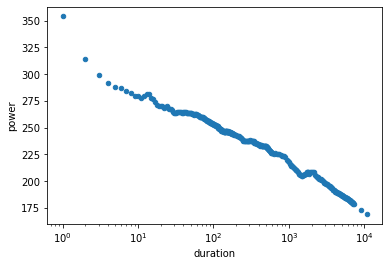

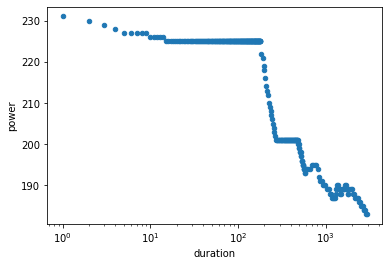

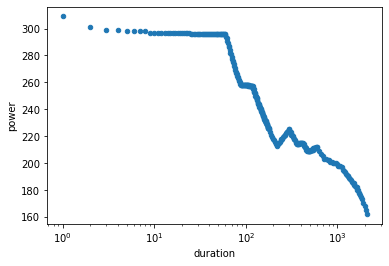

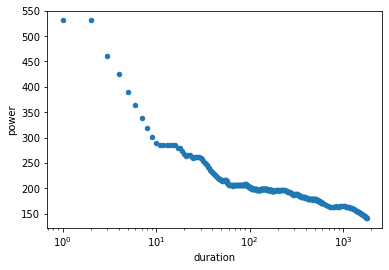

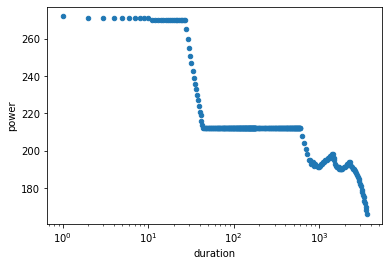

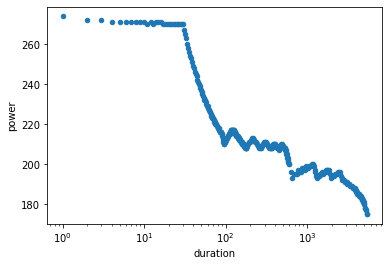

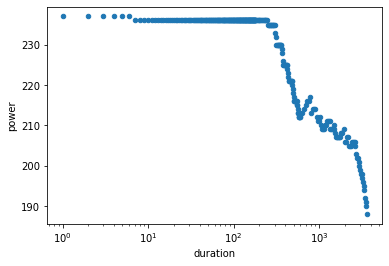

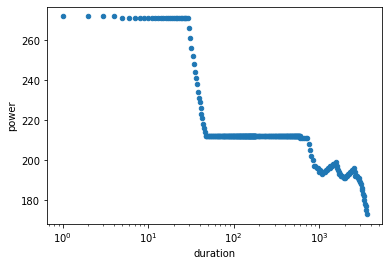

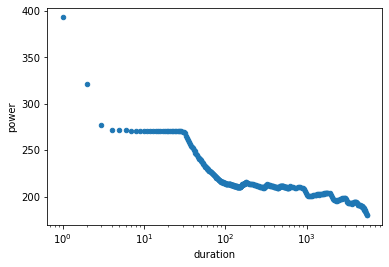

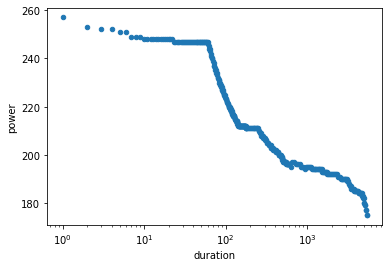

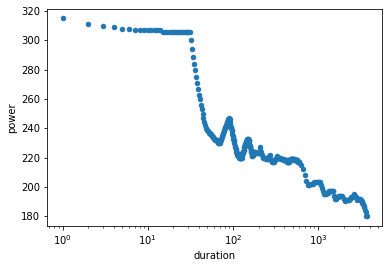

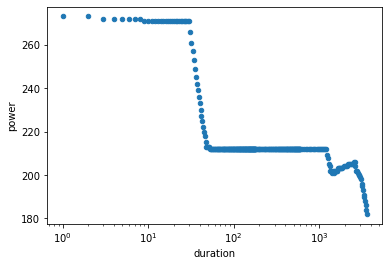

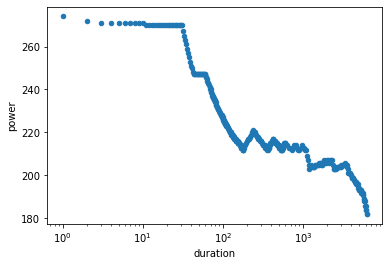

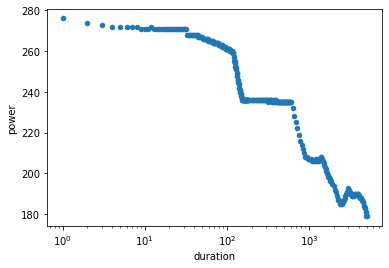

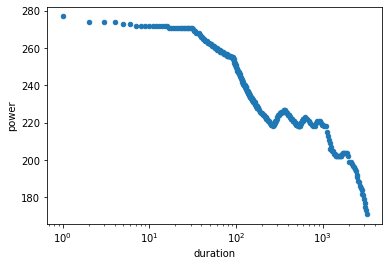

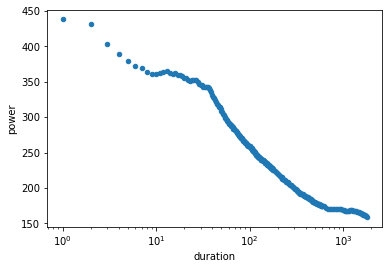

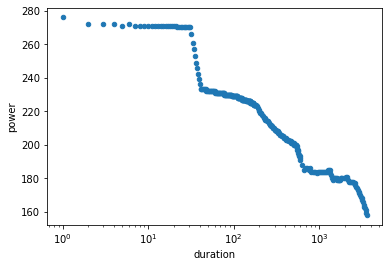

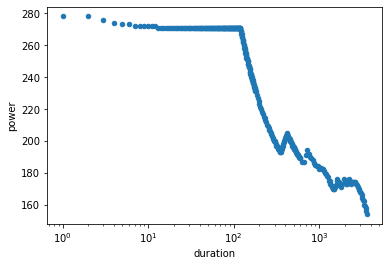

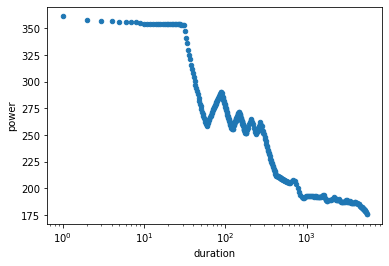

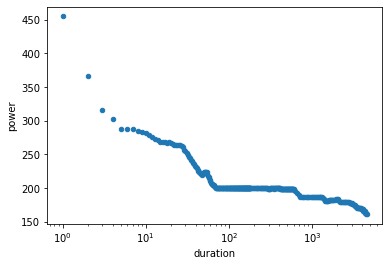

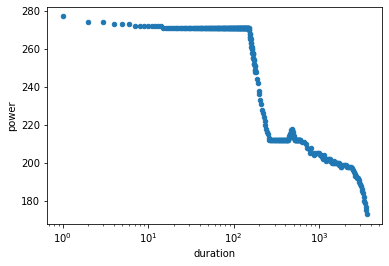

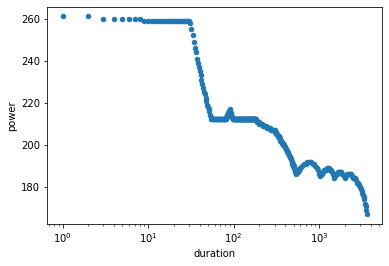

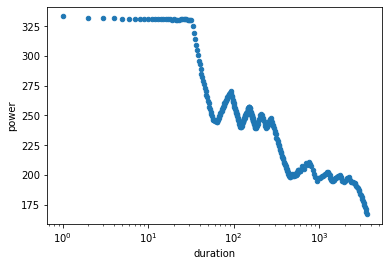

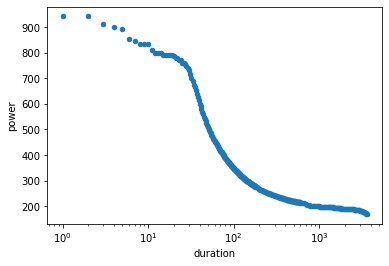

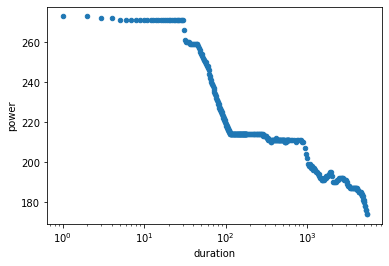

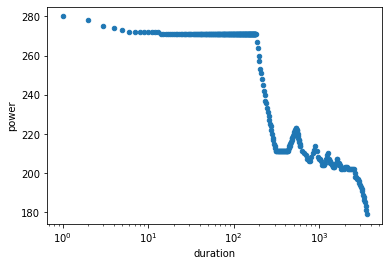

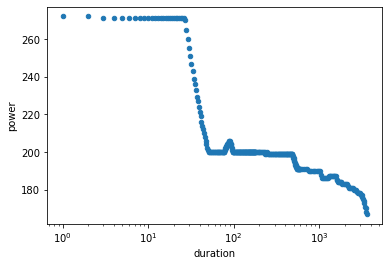

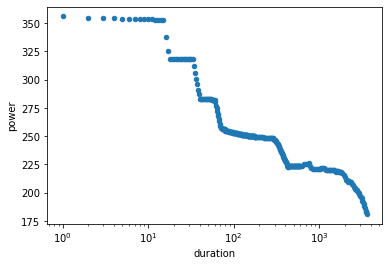

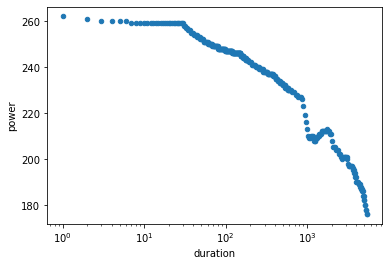

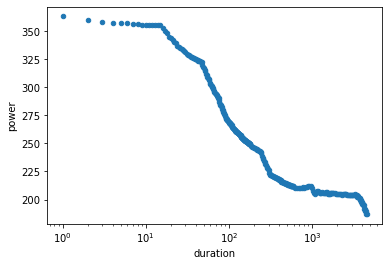

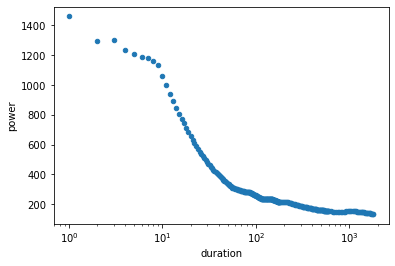

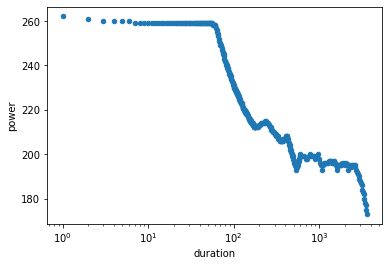

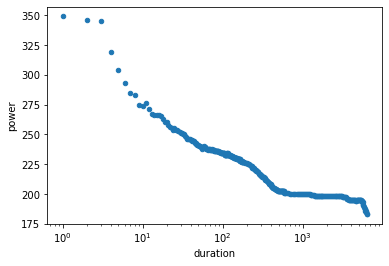

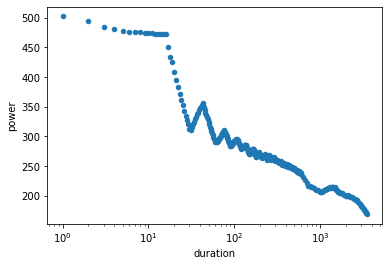

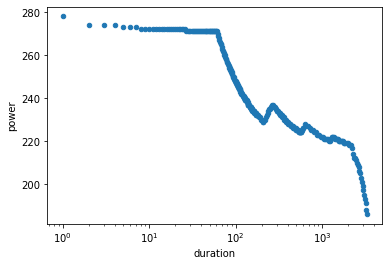

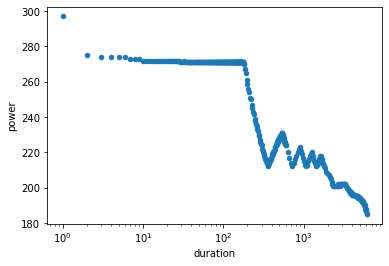

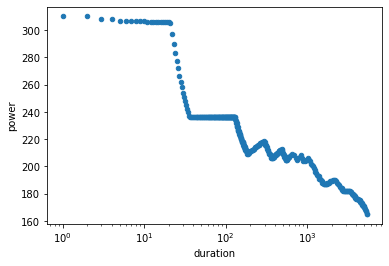

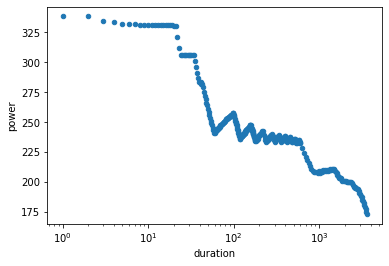

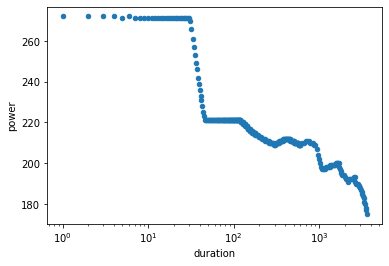

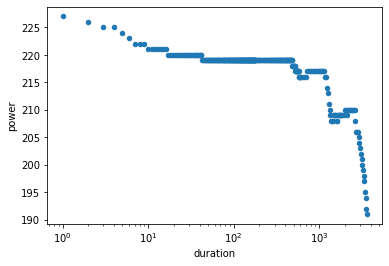

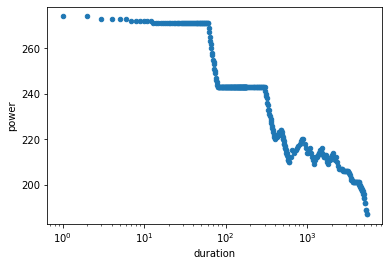

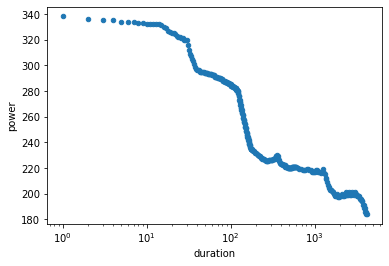

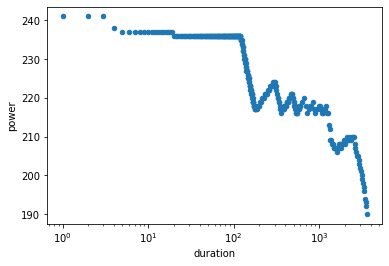

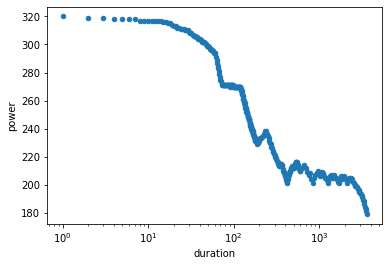

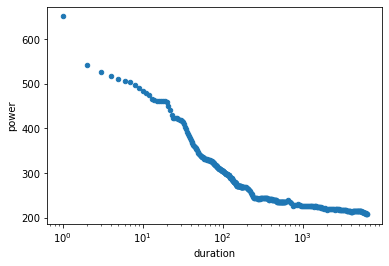

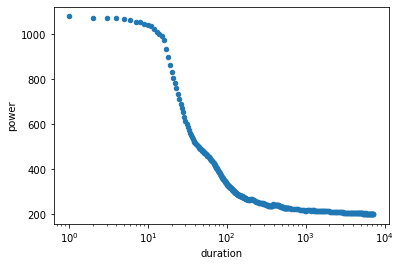

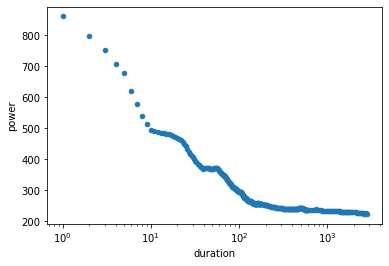

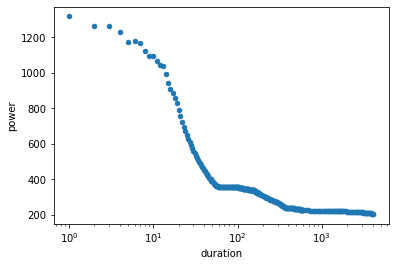

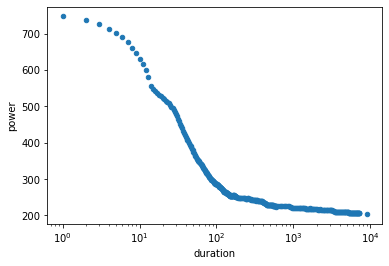

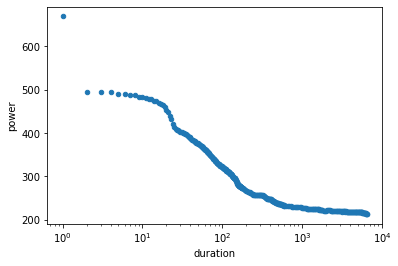

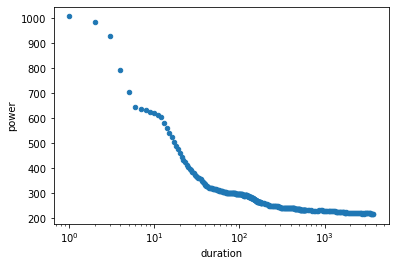

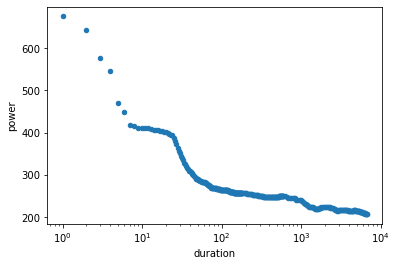

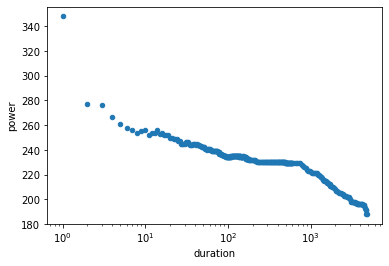

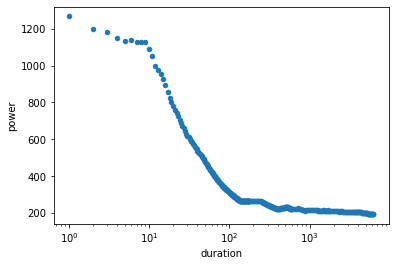

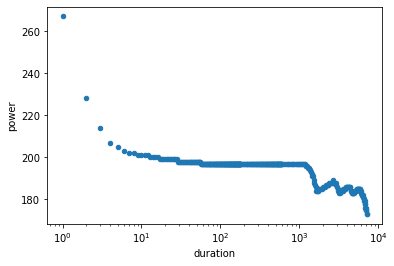

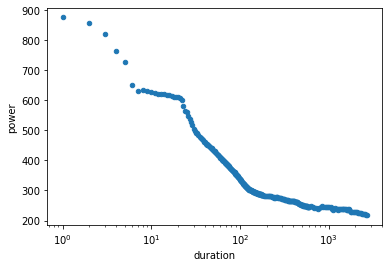

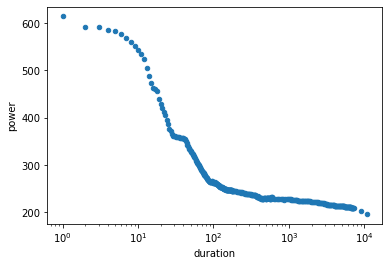

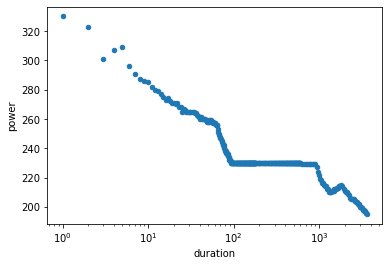

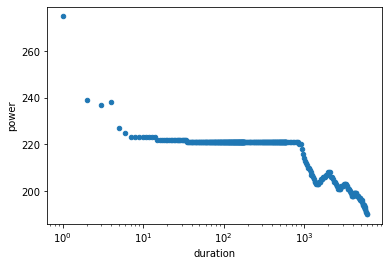

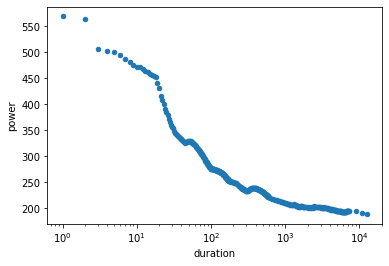

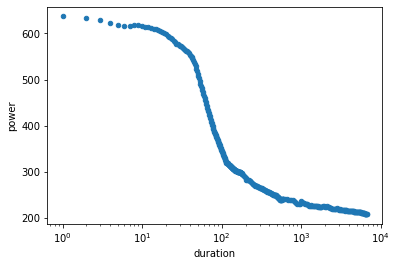

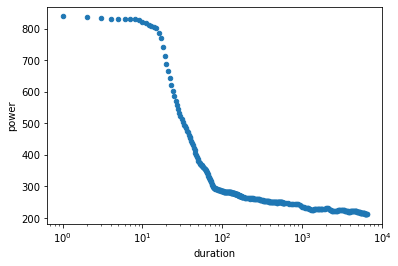

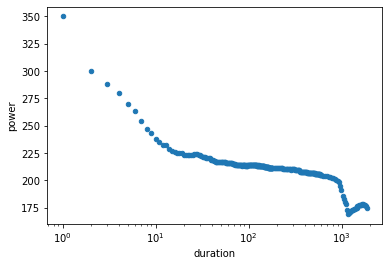

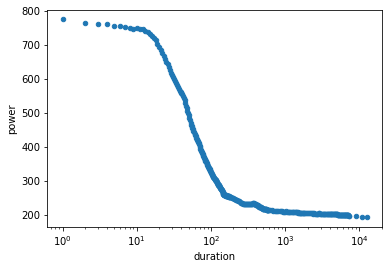

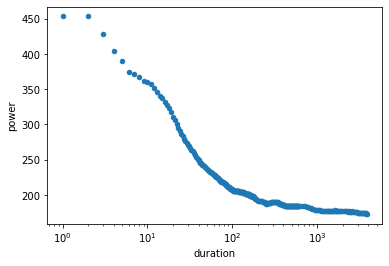

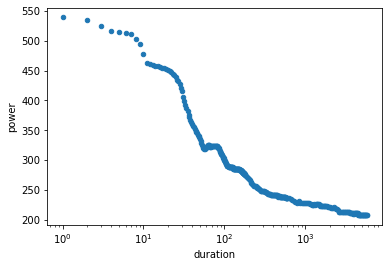

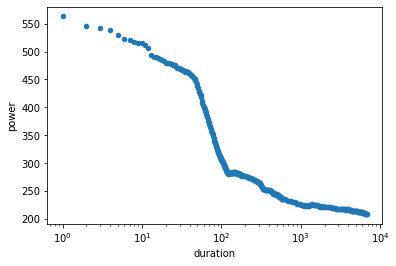

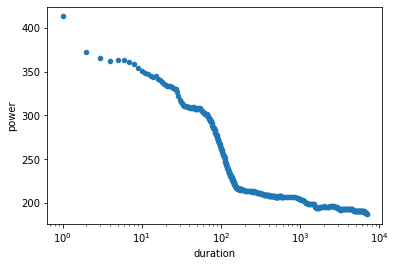

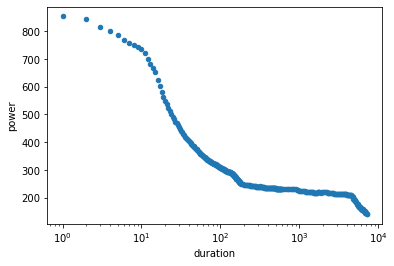

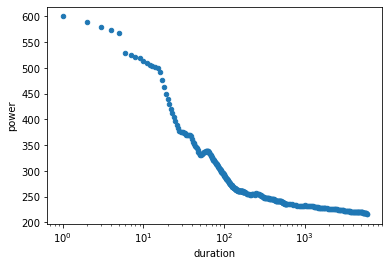

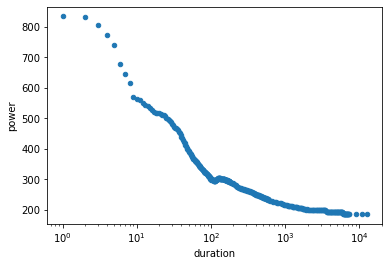

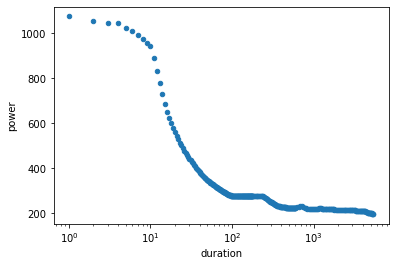

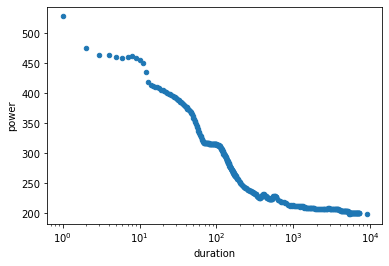

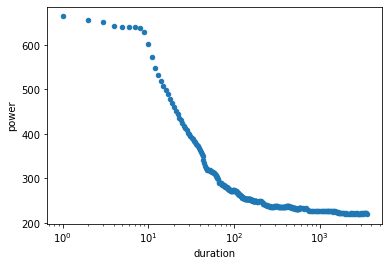

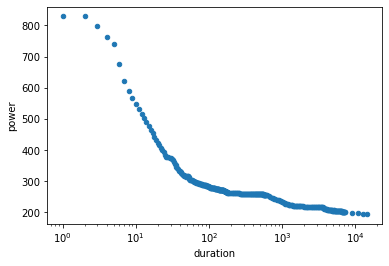

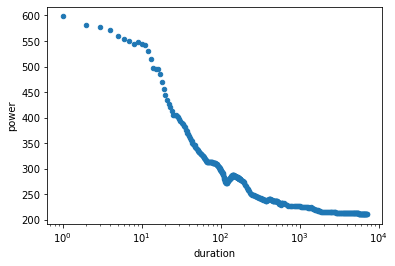

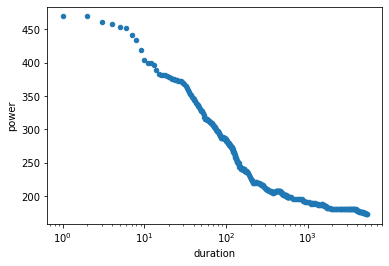

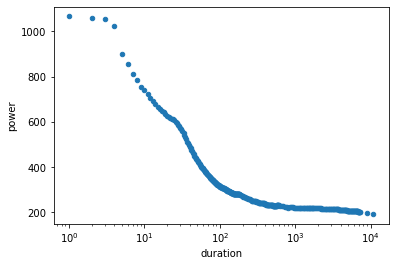

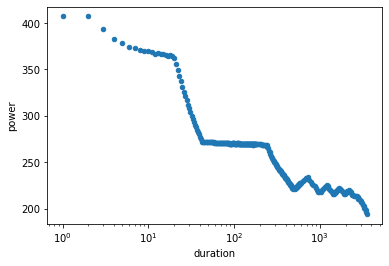

In [22]:
for activity in bike_activities[:6]:
    df = pd.DataFrame({'duration':activity.metadata['METRICS']['power_mmp_secs'], 'power':activity.metadata['METRICS']['power_mmp']})
    df.plot('duration', 'power', kind='scatter', logx=True)

## Create power curve based on all of activities for chosen athlete

In [23]:
power_curve = {}
for activity in bike_activities:
    for i in range(len(activity.metadata['METRICS']['power_mmp_secs'])):
        if activity.metadata['METRICS']['power_mmp_secs'][i] in power_curve:
            power_curve[activity.metadata['METRICS']['power_mmp_secs'][i]] = max(power_curve[activity.metadata['METRICS']['power_mmp_secs'][i]],activity.metadata['METRICS']['power_mmp'][i])
        else:
            power_curve[activity.metadata['METRICS']['power_mmp_secs'][i]] = activity.metadata['METRICS']['power_mmp'][i]

In [24]:
power_curve[:20]

{1: 1460,
 2: 1316,
 3: 1309,
 4: 1305,
 5: 1273,
 6: 1247,
 7: 1192,
 8: 1164,
 9: 1137,
 10: 1096,
 11: 1077,
 12: 1057,
 13: 1040,
 14: 1025,
 15: 1007,
 16: 990,
 17: 975,
 18: 959,
 19: 939,
 20: 912,
 21: 884,
 22: 856,
 23: 827,
 24: 801,
 25: 776,
 26: 758,
 27: 756,
 28: 747,
 29: 739,
 30: 731,
 31: 716,
 32: 701,
 33: 687,
 34: 674,
 35: 666,
 36: 652,
 37: 638,
 38: 625,
 39: 613,
 40: 601,
 41: 590,
 42: 579,
 43: 569,
 44: 559,
 45: 550,
 46: 541,
 47: 532,
 48: 524,
 49: 518,
 50: 512,
 51: 507,
 52: 503,
 53: 496,
 54: 491,
 55: 487,
 56: 482,
 57: 478,
 58: 474,
 59: 469,
 60: 465,
 61: 460,
 62: 456,
 63: 452,
 64: 448,
 65: 443,
 66: 439,
 67: 435,
 68: 431,
 69: 428,
 70: 424,
 71: 420,
 72: 416,
 73: 412,
 74: 409,
 75: 405,
 76: 402,
 77: 399,
 78: 395,
 79: 392,
 80: 389,
 81: 386,
 82: 384,
 83: 382,
 84: 380,
 85: 378,
 86: 375,
 87: 373,
 88: 371,
 89: 369,
 90: 367,
 91: 366,
 92: 365,
 93: 365,
 94: 365,
 95: 364,
 96: 364,
 97: 363,
 98: 362,
 99: 361,
 100

In [25]:
len(power_curve)

398

In [26]:
power_curve_DF = pd.DataFrame.from_dict(power_curve, orient='index')

In [ ]:
power_curve_DF.reset_index()[:100]

<AxesSubplot:>

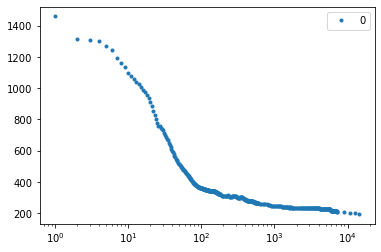

In [28]:
power_curve_DF.plot(style='.',logx=True)

# Creating dataframe with interesting data of all activities for chosen athlete

In [29]:
def month(df):
    return parse(df['date']).month

In [32]:
def create_athlete_dataset(data):
    criticalPower = pd.DataFrame()
    titles = ['activity','athlete','date','weight','duration','coggan_tss','np']
    for activity in tqdm(data):
        rows = criticalPower
        s2 = pd.Series(activity.metadata['METRICS']['power_mmp'], index=activity.metadata['METRICS']['power_mmp_secs'])
        s1 = pd.Series([activity.id,random_athlete.id,activity.metadata['date'],activity.metadata['METRICS']['athlete_weight'],activity.metadata['METRICS']['time_riding'],activity.metadata['METRICS']['coggan_tss'],activity.metadata['METRICS']['coggan_np'][0]],index=titles)
        row = pd.concat([s1,s2])
        criticalPower = pd.concat([rows, row.to_frame().T], ignore_index=True)
    criticalPower['month'] = criticalPower.apply(lambda row: month(row), axis=1)
    return criticalPower


In [ ]:
PowerDF_athlete = create_athlete_dataset(bike_activities)
PowerDF_athlete.head(20)

# Prepairing data to creating DataFrame of all activities for many athletes

## Read athletes.csv file to fast find who has no lest than 200 activities and then collect their data localy

In [ ]:
AthleteDF = pd.read_csv('athletes.csv')
AthleteDF.head(20)

In [35]:
local_athletes = list(od.local_athletes())
len(local_athletes)

119

In [36]:
#local_athletes_id = []
#for ath in tqdm(local_athletes):
#    local_athletes_id = local_athletes_id + [ath.id]

## Store locally athletes with no less then 200 bike activities

Too long way...

def filter_athletes(athletes):
    filtered_athletes = []
    for athlete in tqdm(athletes):
        i = 0
        try:
            activities = list(athlete.activities())
        except:
            continue
        try:
            for activ in activities:
                if (activ.metadata['sport'] == 'Bike'):
                    i = i + 1
                if (i >= 100):
                    filtered_athletes.append(athlete)
                    athlete.store_locally()
                    break
        except:
            continue
    return filtered_athletes

filtered_athletes = filter_athletes(athletes)
len(filtered_athletes)

A bit clever trick:

In [37]:
def download_athletes(DataFrame):
    athletes = []
    for i, row in tqdm(DataFrame.iterrows()):
        if (row['bike'] >= 200 and row['run'] < 10 and row['swim'] < 10):
            #if row['id'] not in local_athletes_id:
            athlete = row['id']
            athletes.append(athlete)
    return athletes

In [38]:
interesting_athletes = download_athletes(AthleteDF)
len(interesting_athletes)

6043it [00:00, 8267.37it/s]


1513

In [39]:
n = 0
for athlete_id in tqdm(interesting_athletes):
    if athlete_id not in local_athletes:
        athlete = od.get_remote_athlete(athlete_id)
        athlete.store_locally()
    n = n + 1
    if(n == 300):
        break

 20%|██████▉                            | 299/1513 [4:01:50<16:21:54, 48.53s/it]


In [40]:
local_athletes = list(od.local_athletes())
len(local_athletes)

300

# Creating dataframe with power data of all activities for 300 athletes

In [41]:
local_athletes = list(od.local_athletes())

In [42]:
def create_dataframe():
    criticalPower = pd.DataFrame()
    activity_id = []
    athlete_id = []
    date = []
    weight = []
    duration = []
    #coggan_tss = []
    np = []
    power_1200s = []
    for athlete in tqdm(local_athletes):
        activities = list(athlete.activities())
        for activity in activities:
            try:
                if ('power_mmp_secs' in activity.metadata['METRICS'] and 'athlete_weight' in activity.metadata['METRICS'] and 'time_riding' in activity.metadata['METRICS'] and 'coggan_np' in activity.metadata['METRICS']):
                    if(len(activity.metadata['METRICS']['power_mmp']) > 284):
                        power_1200s = power_1200s + [activity.metadata['METRICS']['power_mmp'][284]]
                    else:
                        power_1200s = power_1200s + [math.nan]
                    activity_id = activity_id + [activity.id]
                    athlete_id = athlete_id + [athlete.id]
                    date = date + [activity.metadata['date']]
                    weight = weight + [activity.metadata['METRICS']['athlete_weight']]
                    duration = duration + [activity.metadata['METRICS']['time_riding']]
                    #coggan_tss = [activity.metadata['METRICS']['coggan_tss']]
                    np = np + [activity.metadata['METRICS']['coggan_np'][0]]
            except:
                continue
    print(f'len activity: {len(activity_id)}')
    print(f'len athlete: {len(athlete_id)}')
    print(f'len date: {len(date)}')
    print(f'len weight: {len(weight)}')
    print(f'len duration: {len(duration)}')
    #print(f'len coggan_tss: {len(coggan_tss)}')
    print(f'len np: {len(np)}')
    print(f'len power_1200s: {len(power_1200s)}')

    criticalPower['activity'] = activity_id
    criticalPower['athlete'] = athlete_id
    criticalPower['date'] = date
    criticalPower['weight'] = weight
    criticalPower['duration'] = duration
    #criticalPower['coggan_tss'] = coggan_tss
    criticalPower['np'] = np
    criticalPower['power_1200s'] = power_1200s
    try:
        criticalPower['month'] = criticalPower.apply(lambda row: month(row), axis=1)
        return criticalPower
    except:
        return criticalPower

In [43]:
PowerDF = create_dataframe()
PowerDF.head(20)

100%|███████████████████████████████████████| 300/300 [1:28:32<00:00, 17.71s/it]


len activity: 157707
len athlete: 157707
len date: 157707
len weight: 157707
len duration: 157707
len np: 157707
len power_1200s: 157707


activity                               athlete  \
0   2018_02_14_12_54_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
1   2018_02_15_10_55_37.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
2   2018_02_16_11_27_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
3   2018_02_17_09_11_17.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
4   2018_02_18_06_29_10.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
5   2018_02_18_08_23_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
6   2018_02_19_06_35_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
7   2018_02_20_09_43_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
8   2018_02_23_16_13_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
9   2018_02_24_16_14_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
10  2018_02_25_11_17_20.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
11  2018_02_25_15_26_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
12  2018_02_25_15_57_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
13  2018_02_26_14_19_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
14  2018_02_27_09_17_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
15  2018_02_28_11_02_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
16  2018_03_01_08_48_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
17  2018_03_02_07_45_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
18  2018_03_02_10_13_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
19  2018_03_04_09_40_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
20  2018_03_06_09_57_26.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
21  2018_03_07_07_49_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
22  2018_03_09_10_13_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
23  2018_03_10_07_07_56.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
24  2018_03_11_09_15_42.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
25  2018_03_12_13_35_09.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
26  2018_03_13_09_50_18.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
27  2018_03_14_10_21_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
28  2018_03_17_09_10_45.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
29  2018_03_18_09_26_15.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
30  2018_03_19_07_10_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
31  2018_03_20_10_08_51.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
32  2018_03_21_14_56_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
33  2018_03_22_07_54_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
34  2018_03_23_08_51_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
35  2018_03_24_06_47_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
36  2018_03_25_07_21_46.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
37  2018_03_28_11_27_00.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
38  2018_03_29_13_46_29.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
39  2018_03_30_07_34_25.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
40  2018_03_31_06_24_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
41  2018_04_01_08_14_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
42  2018_04_04_10_32_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
43  2018_04_05_06_39_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
44  2018_04_07_05_29_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
45  2018_04_08_07_57_13.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
46  2018_04_09_12_20_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
47  2018_04_10_08_54_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
48  2018_04_11_13_03_35.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
49  2018_04_12_13_15_44.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
50  2018_04_13_06_43_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
51  2018_04_14_06_22_06.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
52  2018_04_15_12_26_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
53  2018_04_17_06_41_58.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
54  2018_04_18_16_49_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
55  2018_04_19_06_44_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
56  2018_04_20_07_34_32.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
57  2018_04_21_07

# Function calculating ftp per month:

In [44]:
def calc_ftp(dataFrame):
    x = 0
    mon = dataFrame['month'][0]
    athlete = dataFrame['athlete'][0]
    monftp = []
    ftp = []
    acc = []
    for i, row in tqdm(dataFrame.iterrows()):
        if(mon == row['month'] and athlete == row['athlete']):
            if(np.isnan(row['power_1200s'])):
                acc = acc + [0]
            else:
                acc = acc + [row['power_1200s']]
        else:
            monftp = [max(acc) * 0.95] * x
            ftp = ftp + monftp
            x = 0
            monftp = []
            acc = []
            mon = row['month']
            athlete = row['athlete']
            if(np.isnan(row['power_1200s'])):
                acc = acc + [0]
            else:
                acc = acc + [row['power_1200s']]
        x = x + 1
    monftp = [max(acc) * 0.95] * x
    ftp = ftp + monftp
    return ftp

In [45]:
PowerDF['ftp'] = calc_ftp(PowerDF)
PowerDF.head(20)

157707it [00:32, 4906.11it/s]


activity                               athlete  \
0   2018_02_14_12_54_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
1   2018_02_15_10_55_37.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
2   2018_02_16_11_27_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
3   2018_02_17_09_11_17.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
4   2018_02_18_06_29_10.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
5   2018_02_18_08_23_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
6   2018_02_19_06_35_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
7   2018_02_20_09_43_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
8   2018_02_23_16_13_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
9   2018_02_24_16_14_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
10  2018_02_25_11_17_20.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
11  2018_02_25_15_26_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
12  2018_02_25_15_57_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
13  2018_02_26_14_19_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
14  2018_02_27_09_17_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
15  2018_02_28_11_02_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
16  2018_03_01_08_48_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
17  2018_03_02_07_45_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
18  2018_03_02_10_13_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
19  2018_03_04_09_40_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
20  2018_03_06_09_57_26.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
21  2018_03_07_07_49_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
22  2018_03_09_10_13_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
23  2018_03_10_07_07_56.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
24  2018_03_11_09_15_42.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
25  2018_03_12_13_35_09.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
26  2018_03_13_09_50_18.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
27  2018_03_14_10_21_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
28  2018_03_17_09_10_45.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
29  2018_03_18_09_26_15.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
30  2018_03_19_07_10_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
31  2018_03_20_10_08_51.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
32  2018_03_21_14_56_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
33  2018_03_22_07_54_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
34  2018_03_23_08_51_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
35  2018_03_24_06_47_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
36  2018_03_25_07_21_46.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
37  2018_03_28_11_27_00.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
38  2018_03_29_13_46_29.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
39  2018_03_30_07_34_25.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
40  2018_03_31_06_24_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
41  2018_04_01_08_14_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
42  2018_04_04_10_32_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
43  2018_04_05_06_39_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
44  2018_04_07_05_29_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
45  2018_04_08_07_57_13.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
46  2018_04_09_12_20_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
47  2018_04_10_08_54_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
48  2018_04_11_13_03_35.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
49  2018_04_12_13_15_44.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
50  2018_04_13_06_43_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
51  2018_04_14_06_22_06.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
52  2018_04_15_12_26_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
53  2018_04_17_06_41_58.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
54  2018_04_18_16_49_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
55  2018_04_19_06_44_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
56  2018_04_20_07_34_32.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
57  2018_04_21_07

# Calculating power zones for every activity

Of course in one month power zones will not change

In [46]:
def calc_power_zones(dataFrame):
    athlete = ''
    mon = 0
    onePZ = []
    onePZ_acc = 0
    twoPZ = []
    twoPZ_acc = 0
    threePZ = []
    threePZ_acc = 0
    fourPZ = []
    fourPZ_acc = 0
    fivePZ = []
    fivePZ_acc = 0
    sixPZ = []
    sixPZ_acc = 0
    for i, row in tqdm(dataFrame.iterrows()):
        
        if (i == 0):
            athlete = row['athlete']
            mon = row['month']
            onePZ_acc = 0.55 * row['ftp']
            twoPZ_acc = 0.75 * row['ftp']
            threePZ_acc = 0.9 * row['ftp']
            fourPZ_acc = 1.05 * row['ftp']
            fivePZ_acc = 1.2 * row['ftp']
            sixPZ_acc = 1.5 * row['ftp']
            
            onePZ = onePZ + [onePZ_acc]
            twoPZ = twoPZ + [twoPZ_acc]
            threePZ = threePZ + [threePZ_acc]
            fourPZ = fourPZ + [fourPZ_acc]
            fivePZ = fivePZ + [fivePZ_acc]
            sixPZ = sixPZ + [sixPZ_acc]
            
        elif (mon == row['month'] and athlete == row['athlete']):
            onePZ = onePZ + [onePZ_acc]
            twoPZ = twoPZ + [twoPZ_acc]
            threePZ = threePZ + [threePZ_acc]
            fourPZ = fourPZ + [fourPZ_acc]
            fivePZ = fivePZ + [fivePZ_acc]
            sixPZ = sixPZ + [sixPZ_acc]
            
        else:
            onePZ_acc = 0.55 * row['ftp']
            twoPZ_acc = 0.75 * row['ftp']
            threePZ_acc = 0.9 * row['ftp']
            fourPZ_acc = 1.05 * row['ftp']
            fivePZ_acc = 1.2 * row['ftp']
            sixPZ_acc = 1.5 * row['ftp']
            
            onePZ = onePZ + [onePZ_acc]
            twoPZ = twoPZ + [twoPZ_acc]
            threePZ = threePZ + [threePZ_acc]
            fourPZ = fourPZ + [fourPZ_acc]
            fivePZ = fivePZ + [fivePZ_acc]
            sixPZ = sixPZ + [sixPZ_acc]
            
        mon = row['month']
        athlete = row['athlete']
    return onePZ, twoPZ, threePZ, fourPZ, fivePZ, sixPZ

In [47]:
PowerDF['1_power_zone'], PowerDF['2_power_zone'], PowerDF['3_power_zone'], PowerDF['4_power_zone'], PowerDF['5_power_zone'], PowerDF['6_power_zone'] = calc_power_zones(PowerDF)
PowerDF.head(20)

157707it [09:51, 266.57it/s]


activity                               athlete  \
0   2018_02_14_12_54_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
1   2018_02_15_10_55_37.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
2   2018_02_16_11_27_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
3   2018_02_17_09_11_17.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
4   2018_02_18_06_29_10.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
5   2018_02_18_08_23_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
6   2018_02_19_06_35_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
7   2018_02_20_09_43_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
8   2018_02_23_16_13_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
9   2018_02_24_16_14_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
10  2018_02_25_11_17_20.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
11  2018_02_25_15_26_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
12  2018_02_25_15_57_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
13  2018_02_26_14_19_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
14  2018_02_27_09_17_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
15  2018_02_28_11_02_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
16  2018_03_01_08_48_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
17  2018_03_02_07_45_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
18  2018_03_02_10_13_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
19  2018_03_04_09_40_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
20  2018_03_06_09_57_26.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
21  2018_03_07_07_49_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
22  2018_03_09_10_13_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
23  2018_03_10_07_07_56.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
24  2018_03_11_09_15_42.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
25  2018_03_12_13_35_09.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
26  2018_03_13_09_50_18.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
27  2018_03_14_10_21_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
28  2018_03_17_09_10_45.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
29  2018_03_18_09_26_15.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
30  2018_03_19_07_10_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
31  2018_03_20_10_08_51.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
32  2018_03_21_14_56_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
33  2018_03_22_07_54_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
34  2018_03_23_08_51_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
35  2018_03_24_06_47_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
36  2018_03_25_07_21_46.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
37  2018_03_28_11_27_00.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
38  2018_03_29_13_46_29.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
39  2018_03_30_07_34_25.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
40  2018_03_31_06_24_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
41  2018_04_01_08_14_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
42  2018_04_04_10_32_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
43  2018_04_05_06_39_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
44  2018_04_07_05_29_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
45  2018_04_08_07_57_13.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
46  2018_04_09_12_20_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
47  2018_04_10_08_54_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
48  2018_04_11_13_03_35.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
49  2018_04_12_13_15_44.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
50  2018_04_13_06_43_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
51  2018_04_14_06_22_06.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
52  2018_04_15_12_26_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
53  2018_04_17_06_41_58.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
54  2018_04_18_16_49_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
55  2018_04_19_06_44_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
56  2018_04_20_07_34_32.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
57  2018_04_21_07

# Finding which activity is not local storage and destroy time in zones calculations

In [48]:
athletes_in_dataset = list(PowerDF['athlete'].unique())
athletes_in_dataset[:20]

['be3b662e-6fda-4c4f-85f8-812a364657f7',
 '705d4ac7-258c-42d6-9ff6-c74b3dbb04c7',
 '939eabb2-f1e4-4bce-8281-2baf58a8f772',
 '4727f484-f08d-48cd-b680-e3625aaa5d50',
 '810e205d-4e6c-4473-a5c4-a8b7568da315',
 '1bc1499d-9370-44a7-a2b8-cd1e8fabd8cd',
 '48a39786-5000-457c-b6d3-5f923e8f76a4',
 '6257f49d-0fa5-4eab-aa1f-7fe90c6aac67',
 'fa200051-3b4d-4509-b358-215094243f3e',
 'cf500e04-d5d4-428c-9106-8542720fe632',
 'adf7d4fc-8b3f-410c-81c2-7b713d659d1a',
 '9689a8d0-1cb1-42f6-83e4-fc0c8f6db31b',
 'c5245352-be7e-4382-b890-fa3283b1fd09',
 '9abb1be0-0f37-4014-ba36-a95568f2b105',
 'cf70e2a1-ad11-48dd-b836-265fadd0fcc2',
 '72bb0b9a-d866-4bca-a69b-89a93484d305',
 'ff64b289-b9d9-4927-8c7b-c4ba3a9945a1',
 'bd104cd6-e1c4-4724-967a-d3ee321d86a4',
 'ce043e2d-a873-49cb-a398-c6ce020877df',
 '6de3e82e-9d67-4c81-803e-88ccc69047a9',
 '4c08148d-096e-4593-8a67-2d08d4035df5',
 '42582e78-b367-42f3-9e79-8236c9abd526',
 '9e5e8829-e123-40cd-9f93-ab8385af4b0c',
 'f64ea63f-b74b-46a6-a677-8293ecf82daf',
 '2a95ee21-cde4-

In [49]:
path = '/Volumes/Mati_Data/data'
for folder_name in os.listdir(path):
    if folder_name not in athletes_in_dataset:
        full_folder_path = os.path.join(path, folder_name)
        st.rmtree(full_folder_path)

In [50]:
path = '/Volumes/Mati_Data/metadata'
for file_name in os.listdir(path):
    if file_name not in athletes_in_dataset:
        full_file_path = os.path.join(path, file_name)
        os.remove(full_file_path)

In [51]:
for athlete_id in tqdm(athletes_in_dataset):
    athlete = od.get_remote_athlete(athlete_id)
    athlete.store_locally(data=False)

100%|█████████████████████████████████████████| 297/297 [21:27<00:00,  4.33s/it]


In [52]:
for athlete_id in tqdm(athletes_in_dataset):
    local_athlete = LocalAthlete(athlete_id)
    local_athlete.download_remote_data()

100%|███████████████████████████████████████| 297/297 [3:49:04<00:00, 46.28s/it]


In [54]:
miss_files = {}
athlete_id = ''
athlete_path = ''
file_list = []
path = '/Volumes/Mati_Data/data'
iterator = 0
for i,row in tqdm(PowerDF.iterrows()):
    if (i == 0):
        athlete_id = row['athlete']
        athlete_path = os.path.join(path, athlete_id)
        file_list = [activ for activ in os.listdir(path)]
    elif (athlete_id != row['athlete']):
        athlete_id = row['athlete']
        athlete_path = os.path.join(path, athlete_id)
        file_list = [activ for activ in os.listdir(athlete_path)]
    if row['activity'] in file_list:
        pass
    else:
        iterator = iterator + 1
        miss_files[iterator] = [athlete_id, row['activity']]
print(len(miss_files))
miss_files[:20]

157707it [01:11, 2199.20it/s] 

463


{1: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_14_12_54_23.csv'],
 2: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_15_10_55_37.csv'],
 3: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_16_11_27_08.csv'],
 4: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_17_09_11_17.csv'],
 5: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_18_06_29_10.csv'],
 6: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_18_08_23_07.csv'],
 7: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_19_06_35_49.csv'],
 8: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_20_09_43_33.csv'],
 9: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_23_16_13_07.csv'],
 10: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_24_16_14_11.csv'],
 11: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_25_11_17_20.csv'],
 12: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_25_15_26_16.csv'],
 13: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '2018_02_25_15_57_02.csv'],
 14: ['be3b662e-6fda-4c4f-85f8-812a364657f7', '

In [ ]:
PowerDF = PowerDF.drop(463)

In [ ]:
len(PowerDF)

# Calculating time spent in every power zone

In [56]:
def time_in_zones(dataFrame):
    time_in_zone1 = []
    time_in_zone2 = []
    time_in_zone3 = []
    time_in_zone4 = []
    time_in_zone5 = []
    time_in_zone6 = []
    time_in_zone7 = []
    z1 = 0
    z2 = 0
    z3 = 0
    z4 = 0
    z5 = 0
    z6 = 0
    time_z1 = 0
    time_z2 = 0
    time_z3 = 0
    time_z4 = 0
    time_z5 = 0
    time_z6 = 0
    time_z7 = 0
    month = 0
    athlete_id = dataFrame['athlete'][0]
    athlete = od.get_local_athlete(athlete_id)
    #athlete_activities = list(athlete.activities())
    to_delete = {}
    for i, row in tqdm(dataFrame.iterrows()):
        if (i == 0):
            z1 = row['1_power_zone']
            z2 = row['2_power_zone']
            z3 = row['3_power_zone']
            z4 = row['4_power_zone']
            z5 = row['5_power_zone']
            z6 = row['6_power_zone']
            month = row['month']
        elif (z1 != row['1_power_zone'] or athlete_id != row['athlete'] or month != row['month']):
            z1 = row['1_power_zone']
            z2 = row['2_power_zone']
            z3 = row['3_power_zone']
            z4 = row['4_power_zone']
            z5 = row['5_power_zone']
            z6 = row['6_power_zone']
            month = row['month']
            if (athlete_id != row['athlete']):
                athlete_id = row['athlete']
                athlete = od.get_local_athlete(athlete_id)
                #athlete_activities = list(athlete.activities())
        activity = athlete.get_activity(row['activity'])
        #if activity in athlete_activities:
        try:
            for i, row in activity.data.iterrows():
                if (row['power'] <= z1 and row['power'] > 0):
                    time_z1 = time_z1 + 1
                elif (row['power'] <= z2 and row['power'] > z1):
                    time_z2 = time_z2 + 1
                elif (row['power'] <= z3 and row['power'] > z2):
                    time_z3 = time_z3 + 1
                elif (row['power'] <= z4 and row['power'] > z3):
                    time_z4 = time_z4 + 1
                elif (row['power'] <= z5 and row['power'] > z4):
                    time_z5 = time_z5 + 1
                elif (row['power'] <= z6 and row['power'] > z5):
                    time_z6 = time_z6 + 1
                elif (row['power'] > z6):
                    time_z7 = time_z7 + 1
            time_in_zone1 = time_in_zone1 + [time_z1]
            time_in_zone2 = time_in_zone2 + [time_z2]
            time_in_zone3 = time_in_zone3 + [time_z3]
            time_in_zone4 = time_in_zone4 + [time_z4]
            time_in_zone5 = time_in_zone5 + [time_z5]
            time_in_zone6 = time_in_zone6 + [time_z6]
            time_in_zone7 = time_in_zone7 + [time_z7]
            time_z1 = 0
            time_z2 = 0
            time_z3 = 0
            time_z4 = 0
            time_z5 = 0
            time_z6 = 0
            time_z7 = 0
        except:
            to_delete[i] = [row['athlete'], row['activity']]
            time_in_zone1 = time_in_zone1 + [0]
            time_in_zone2 = time_in_zone2 + [0]
            time_in_zone3 = time_in_zone3 + [0]
            time_in_zone4 = time_in_zone4 + [0]
            time_in_zone5 = time_in_zone5 + [0]
            time_in_zone6 = time_in_zone6 + [0]
            time_in_zone7 = time_in_zone7 + [0]
            time_z1 = 0
            time_z2 = 0
            time_z3 = 0
            time_z4 = 0
            time_z5 = 0
            time_z6 = 0
            time_z7 = 0
    print(len(to_delete))
    print(to_delete)
    return time_in_zone1, time_in_zone2, time_in_zone3, time_in_zone4, time_in_zone5, time_in_zone6, time_in_zone7

In [57]:
PowerDF['time_in_zone1'], PowerDF['time_in_zone2'], PowerDF['time_in_zone3'], PowerDF['time_in_zone4'], PowerDF['time_in_zone5'], PowerDF['time_in_zone6'], PowerDF['time_in_zone7'] = time_in_zones(PowerDF)
PowerDF.head(20)

157706it [34:37:25,  1.27it/s]


0
{}


activity                               athlete  \
0   2018_02_14_12_54_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
1   2018_02_15_10_55_37.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
2   2018_02_16_11_27_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
3   2018_02_17_09_11_17.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
4   2018_02_18_06_29_10.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
5   2018_02_18_08_23_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
6   2018_02_19_06_35_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
7   2018_02_20_09_43_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
8   2018_02_23_16_13_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
9   2018_02_24_16_14_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
10  2018_02_25_11_17_20.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
11  2018_02_25_15_26_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
12  2018_02_25_15_57_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
13  2018_02_26_14_19_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
14  2018_02_27_09_17_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
15  2018_02_28_11_02_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
16  2018_03_01_08_48_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
17  2018_03_02_07_45_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
18  2018_03_02_10_13_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
19  2018_03_04_09_40_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
20  2018_03_06_09_57_26.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
21  2018_03_07_07_49_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
22  2018_03_09_10_13_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
23  2018_03_10_07_07_56.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
24  2018_03_11_09_15_42.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
25  2018_03_12_13_35_09.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
26  2018_03_13_09_50_18.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
27  2018_03_14_10_21_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
28  2018_03_17_09_10_45.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
29  2018_03_18_09_26_15.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
30  2018_03_19_07_10_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
31  2018_03_20_10_08_51.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
32  2018_03_21_14_56_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
33  2018_03_22_07_54_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
34  2018_03_23_08_51_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
35  2018_03_24_06_47_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
36  2018_03_25_07_21_46.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
37  2018_03_28_11_27_00.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
38  2018_03_29_13_46_29.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
39  2018_03_30_07_34_25.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
40  2018_03_31_06_24_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
41  2018_04_01_08_14_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
42  2018_04_04_10_32_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
43  2018_04_05_06_39_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
44  2018_04_07_05_29_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
45  2018_04_08_07_57_13.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
46  2018_04_09_12_20_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
47  2018_04_10_08_54_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
48  2018_04_11_13_03_35.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
49  2018_04_12_13_15_44.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
50  2018_04_13_06_43_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
51  2018_04_14_06_22_06.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
52  2018_04_15_12_26_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
53  2018_04_17_06_41_58.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
54  2018_04_18_16_49_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
55  2018_04_19_06_44_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
56  2018_04_20_07_34_32.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
57  2018_04_21_07

# TSS calculation function

In [58]:
for i, row in tqdm(PowerDF.iterrows()):
    if(row['ftp'] == 0):
        PowerDF = PowerDF.drop(i)

157706it [00:49, 3159.36it/s] 


In [59]:
def calc_tss(dataFrame):
    tss = []
    for i, row in tqdm(dataFrame.iterrows()):
        tss = tss + [(float(row['duration'])*float(row['np'])*float(row['np'])/float(row['ftp']))/(float(row['ftp'])*3600)*100]
    return tss

In [60]:
PowerDF['tss'] = calc_tss(PowerDF)
PowerDF.head(20)

157416it [03:21, 781.65it/s]


activity                               athlete  \
0   2018_02_14_12_54_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
1   2018_02_15_10_55_37.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
2   2018_02_16_11_27_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
3   2018_02_17_09_11_17.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
4   2018_02_18_06_29_10.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
5   2018_02_18_08_23_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
6   2018_02_19_06_35_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
7   2018_02_20_09_43_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
8   2018_02_23_16_13_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
9   2018_02_24_16_14_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
10  2018_02_25_11_17_20.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
11  2018_02_25_15_26_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
12  2018_02_25_15_57_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
13  2018_02_26_14_19_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
14  2018_02_27_09_17_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
15  2018_02_28_11_02_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
16  2018_03_01_08_48_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
17  2018_03_02_07_45_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
18  2018_03_02_10_13_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
19  2018_03_04_09_40_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
20  2018_03_06_09_57_26.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
21  2018_03_07_07_49_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
22  2018_03_09_10_13_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
23  2018_03_10_07_07_56.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
24  2018_03_11_09_15_42.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
25  2018_03_12_13_35_09.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
26  2018_03_13_09_50_18.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
27  2018_03_14_10_21_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
28  2018_03_17_09_10_45.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
29  2018_03_18_09_26_15.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
30  2018_03_19_07_10_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
31  2018_03_20_10_08_51.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
32  2018_03_21_14_56_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
33  2018_03_22_07_54_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
34  2018_03_23_08_51_50.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
35  2018_03_24_06_47_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
36  2018_03_25_07_21_46.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
37  2018_03_28_11_27_00.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
38  2018_03_29_13_46_29.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
39  2018_03_30_07_34_25.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
40  2018_03_31_06_24_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
41  2018_04_01_08_14_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
42  2018_04_04_10_32_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
43  2018_04_05_06_39_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
44  2018_04_07_05_29_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
45  2018_04_08_07_57_13.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
46  2018_04_09_12_20_52.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
47  2018_04_10_08_54_04.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
48  2018_04_11_13_03_35.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
49  2018_04_12_13_15_44.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
50  2018_04_13_06_43_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
51  2018_04_14_06_22_06.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
52  2018_04_15_12_26_48.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
53  2018_04_17_06_41_58.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
54  2018_04_18_16_49_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
55  2018_04_19_06_44_34.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
56  2018_04_20_07_34_32.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
57  2018_04_21_07

## Adding year of birth of athletes

In [ ]:
def yob (dataFrame):
    yob = []
    for i, row in tqdm(dataFrame.iterrows()):
        yob = yob + [od.get_local_athlete(row['athlete']).yob]
    return yob

In [ ]:
PowerDF = PowerDF.insert(2, 'year of birth', yob(PowerDF))
PowerDF

In [61]:
PowerDF.dtypes

activity          object
athlete           object
date              object
weight            object
duration          object
np                object
power_1200s      float64
month              int64
ftp              float64
1_power_zone     float64
2_power_zone     float64
3_power_zone     float64
4_power_zone     float64
5_power_zone     float64
6_power_zone     float64
time_in_zone1      int64
time_in_zone2      int64
time_in_zone3      int64
time_in_zone4      int64
time_in_zone5      int64
time_in_zone6      int64
time_in_zone7      int64
tss              float64
dtype: object

In [62]:
PowerDF.to_csv('/Users/mateuszbulanda-gorol/Dropbox/Magisterka/power_df.csv', index=False)

In [18]:
PowerDF = pd.read_csv('power_df.csv')
PowerDF.head(20)

activity                               athlete  \
0   2018_02_14_12_54_23.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
1   2018_02_15_10_55_37.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
2   2018_02_16_11_27_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
3   2018_02_17_09_11_17.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
4   2018_02_18_06_29_10.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
5   2018_02_18_08_23_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
6   2018_02_19_06_35_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
7   2018_02_20_09_43_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
8   2018_02_23_16_13_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
9   2018_02_24_16_14_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
10  2018_02_25_11_17_20.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
11  2018_02_25_15_26_16.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
12  2018_02_25_15_57_02.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
13  2018_02_26_14_19_33.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
14  2018_02_27_09_17_07.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
15  2018_02_28_11_02_53.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
16  2018_03_01_08_48_49.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
17  2018_03_02_07_45_39.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
18  2018_03_02_10_13_08.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   
19  2018_03_04_09_40_11.csv  be3b662e-6fda-4c4f-85f8-812a364657f7   

                       date  weight  duration         np  power_1200s  month  \
0   2018/02/14 03:54:23 UTC    55.0   13961.0  145.25988        152.0      2   
1   2018/02/15 01:55:37 UTC    55.0   18214.0  134.91934        165.0      2   
2   2018/02/16 02:27:08 UTC    55.0    8921.0  161.78067        169.0      2   
3   2018/02/17 00:11:17 UTC    55.0   10115.0  168.34300        202.0      2   
4   2018/02/17 21:29:10 UTC    55.0    3286.0  134.67234        174.0      2   
5   2018/02/17 23:23:07 UTC    55.0   12034.0  169.59874        237.0      2   
6   2018/02/18 21:35:49 UTC    55.0   15666.0  163.08889        251.0      2   
7   2018/02/20 00:43:33 UTC    55.0   18824.0  179.74317        207.0      2   
8   2018/02/23 07:13:07 UTC    55.0    1832.0  221.45632        159.0      2   
9   2018/02/24 07:14:11 UTC    55.0    1890.0  200.97265        150.0      2   
10  2018/02/25 02:17:20 UTC    55.0    7521.0  172.46060        160.0      2   
11  2018/02/25 06:26:16 UTC    55.0    1150.0  170.60475        130.0      2   
12  2018/02/25 06:57:02 UTC    55.0    5898.0  247.02932        246.0      2   
13  2018/02/26 05:19:33 UTC    55.0   10848.0  154.51172        165.0      2   
14  2018/02/27 00:17:07 UTC    55.0   14672.0  142.25102        137.0      2   
15  2018/02/28 02:02:53 UTC    55.0    3498.0  126.09755        120.0      2   
16  2018/02/28 23:48:49 UTC    55.0   19237.0  137.39655        172.0      2   
17  2018/03/01 22:45:39 UTC    55.0    2071.0  172.12636        126.0      3   
18  2018/03/02 01:13:08 UTC    55.0   12025.0  101.42086        102.0      3   
19  2018/03/04 00:40:11 UTC    55.0   15376.0  178.63589        251.0      3   

       ftp  1_power_zone  ...  5_power_zone  6_power_zone  time_in_zone1  \
0   238.45      131.1475  ...        286.14       357.675           5701   
1   238.45      131.1475  ...        286.14       357.675           8755   
2   238.45      131.1475  ...        286.14       357.675           3757   
3   238.45      131.1475  ...        286.14       357.675           3607   
4   238.45      131.1475  ...        286.14       357.675           1393   
5   238.45      131.1475  ...        286.14       357.675           4033   
6   238.45      131.1475  ...        286.14       357.675           5918   
7   238.45      131.1475  ...        286.14       357.675           5445   
8   238.45      131.1475  ...        286.14       357.675            365   
9   238.45      131.1475  ...        286.14       357.675            484   
10  238.45      131.1475  ...        286.14       35

# Machine Learning Model

## Prepairing DataFrame with monthly training data

In [19]:
def all_month_data(dataFrame):
    monthlyDF = pd.DataFrame()
    athlete_acc = dataFrame['athlete'][0]
    weight_acc = float(dataFrame['weight'][0])
    month_acc = dataFrame['month'][0]
    ftp_acc = dataFrame['ftp'][0]
    no_activities_acc = 0
    duration_acc = 0
    np_acc = 0
    time_in_zone1_acc = 0
    time_in_zone2_acc = 0
    time_in_zone3_acc = 0
    time_in_zone4_acc = 0
    time_in_zone5_acc = 0
    time_in_zone6_acc = 0
    time_in_zone7_acc = 0
    tss_acc = 0
    athlete = []
    weight = []
    month = []
    ftp = []
    weighted_ftp = []
    no_activities = []
    duration = []
    avg_np = []
    time_in_zone1 = []
    time_in_zone2 = []
    time_in_zone3 = []
    time_in_zone4 = []
    time_in_zone5 = []
    time_in_zone6 = []
    time_in_zone7 = []
    tss = []
    for i, row in tqdm(dataFrame.iterrows()):
        if(month_acc != row['month'] or athlete_acc != row['athlete']):
            athlete = athlete + [athlete_acc]
            weight = weight + [weight_acc]
            month = month + [month_acc]
            ftp = ftp + [ftp_acc]
            weighted_ftp = weighted_ftp + [ftp_acc/weight_acc]
            no_activities = no_activities + [no_activities_acc]
            duration = duration + [duration_acc]
            avg_np = avg_np + [np_acc/no_activities_acc]
            time_in_zone1 = time_in_zone1 + [time_in_zone1_acc]
            time_in_zone2 = time_in_zone2 + [time_in_zone2_acc]
            time_in_zone3 = time_in_zone3 + [time_in_zone3_acc]
            time_in_zone4 = time_in_zone4 + [time_in_zone4_acc]
            time_in_zone5 = time_in_zone5 + [time_in_zone5_acc]
            time_in_zone6 = time_in_zone6 + [time_in_zone6_acc]
            time_in_zone7 = time_in_zone7 + [time_in_zone7_acc]
            tss = tss + [tss_acc]
            no_activities_acc = 0
            duration_acc = 0
            np_acc = 0
            time_in_zone1_acc = 0
            time_in_zone2_acc = 0
            time_in_zone3_acc = 0
            time_in_zone4_acc = 0
            time_in_zone5_acc = 0
            time_in_zone6_acc = 0
            time_in_zone7_acc = 0
            tss_acc = 0
            month_acc = row['month']
            ftp_acc = row['ftp']
            if(athlete_acc != row['athlete']):
                athlete_acc = row['athlete']
                weight_acc = float(row['weight'])
        no_activities_acc = no_activities_acc + 1
        duration_acc = duration_acc + int(float(row['duration']))
        np_acc = np_acc + int(float(row['np']))
        time_in_zone1_acc = time_in_zone1_acc + row['time_in_zone1']
        time_in_zone2_acc = time_in_zone2_acc + row['time_in_zone2']
        time_in_zone3_acc = time_in_zone3_acc + row['time_in_zone3']
        time_in_zone4_acc = time_in_zone4_acc + row['time_in_zone4']
        time_in_zone5_acc = time_in_zone5_acc + row['time_in_zone5']
        time_in_zone6_acc = time_in_zone6_acc + row['time_in_zone6']
        time_in_zone7_acc = time_in_zone7_acc + row['time_in_zone7']
        tss_acc = tss_acc + row['tss']
    monthlyDF['athlete'] = athlete
    monthlyDF['weight'] = weight
    monthlyDF['month'] = month
    monthlyDF['ftp'] = ftp
    monthlyDF['weighted_ftp'] = weighted_ftp
    monthlyDF['no_activities'] = no_activities
    monthlyDF['duration'] = duration
    monthlyDF['avg_np'] = avg_np
    monthlyDF['time_in_zone1'] = time_in_zone1
    monthlyDF['time_in_zone2'] = time_in_zone2
    monthlyDF['time_in_zone3'] = time_in_zone3
    monthlyDF['time_in_zone4'] = time_in_zone4
    monthlyDF['time_in_zone5'] = time_in_zone5
    monthlyDF['time_in_zone6'] = time_in_zone6
    monthlyDF['time_in_zone7'] = time_in_zone7
    monthlyDF['tss'] = tss
    return monthlyDF

In [20]:
MonthlyDF = all_month_data(PowerDF)
MonthlyDF.head(20)

157416it [00:29, 5322.75it/s]


athlete  weight  month     ftp  weighted_ftp  \
0   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      2  238.45      4.335455   
1   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  238.45      4.335455   
2   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  241.30      4.387273   
3   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  247.00      4.490909   
4   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  242.25      4.404545   
5   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  253.65      4.611818   
6   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      8  255.55      4.646364   
7   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      9  234.65      4.266364   
8   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     10  257.45      4.680909   
9   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     11  247.95      4.508182   
10  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     12  242.25      4.404545   
11  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      1  236.55      4.300909   
12  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      2  239.40      4.352727   
13  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  247.00      4.490909   
14  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  239.40      4.352727   
15  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  245.10      4.456364   
16  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  317.30      5.769091   
17  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  238.45      4.335455   
18  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      1  153.90      2.009138   
19  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      2  188.10      2.455614   

    no_activities  duration      avg_np  time_in_zone1  time_in_zone2  \
0              17    167567  166.000000          58753          26293   
1              25    392939  149.600000         147356          45403   
2              23    325440  178.913043          70736          49431   
3              29    385962  174.137931          96111          64222   
4              30    402734  168.233333          96742          64041   
5              28    375466  169.000000         102148          77232   
6              27    408967  179.259259         101061          62091   
7              19    282114  173.631579          67110          31860   
8              26    328960  188.000000          80678          60462   
9              19    146888  185.000000          42118          29345   
10             20    210910  206.950000          48557          30694   
11             20    249378  178.200000          70716          40933   
12             21    218417  183.428571          61095          41264   
13             28    200524  196.428571          62946          32906   
14             31    264791  193.838710          70109          35668   
15             34    403443  203.647059          91178          51097   
16             47    348500  197.744681         109353          67855   
17             19    118612  228.052632          23411          14792   
18              5     23006  126.000000           4761           6439   
19             13     84204  137.615385          27762          21273   

    time_in_zone3  time_in_zone4  time_in_zone5  time_in_zone6  time_in_zone7  \
0           17259          12428           6677           5654           2932   
1           35812          27714          16746          12446           3589   
2           46890          43003          22698          10385           1858   
3           53790          37444          19027          10893           2444   
4           62602          43589          19607           9950           3265   
5           54253          32138          14716           6186           1604   
6           54576          31236          14756          10529           2846   
7           26354          27936          20020          17216           4913   
8           42539          30426          17289          10778      

## Calculating change of FTP

In [21]:
def ftp_change(dataFrame):
    athlete = dataFrame['athlete'][0]
    ftp_acc = dataFrame['ftp'][0]
    ftp_percent_acc = 0
    weighted_ftp_acc = dataFrame['weighted_ftp'][0]
    weighted_ftp_percent_acc = 0
    d_ftp = []
    d_ftp_percent = []
    d_weighted_ftp = []
    d_weighted_ftp_percent = []
    for i, row in tqdm(dataFrame.iterrows()):
        if(i == 0):
            d_ftp = d_ftp + [math.nan]
            d_ftp_percent = d_ftp_percent + [math.nan]
            d_weighted_ftp = d_weighted_ftp + [math.nan]
            d_weighted_ftp_percent = d_weighted_ftp_percent + [math.nan]
            continue
        elif((i+1) == len(dataFrame)):
            d_ftp = d_ftp + [math.nan]
            d_ftp_percent = d_ftp_percent + [math.nan]
            d_weighted_ftp = d_weighted_ftp + [math.nan]
            d_weighted_ftp_percent = d_weighted_ftp_percent + [math.nan]
            break
        elif(athlete == row['athlete']):
            d_ftp_acc = row['ftp'] - ftp_acc
            d_ftp = d_ftp + [d_ftp_acc]
            d_ftp_percent = d_ftp_percent + [d_ftp_acc/row['ftp']]
            d_weighted_ftp_acc = row['weighted_ftp'] - weighted_ftp_acc
            d_weighted_ftp = d_weighted_ftp + [d_weighted_ftp_acc]
            d_weighted_ftp_percent = d_weighted_ftp_percent + [d_weighted_ftp_acc/row['weighted_ftp']]
        else:
            d_ftp = d_ftp + [math.nan]
            d_ftp_percent = d_ftp_percent + [math.nan]
            d_weighted_ftp = d_weighted_ftp + [math.nan]
            d_weighted_ftp_percent = d_weighted_ftp_percent + [math.nan]
        athlete = row['athlete']
        ftp_acc = row['ftp']
        weighted_ftp_acc = row['weighted_ftp']
    return d_ftp, d_ftp_percent, d_weighted_ftp, d_weighted_ftp_percent

In [22]:
MonthlyDF['d_ftp'], MonthlyDF['d_ftp_percent'], MonthlyDF['d_weighted_ftp'], MonthlyDF['d_weighted_ftp_percent'] = ftp_change(MonthlyDF)
MonthlyDF.head(20)

9433it [00:03, 2951.52it/s]


athlete  weight  month     ftp  weighted_ftp  \
0   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      2  238.45      4.335455   
1   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  238.45      4.335455   
2   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  241.30      4.387273   
3   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  247.00      4.490909   
4   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  242.25      4.404545   
5   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  253.65      4.611818   
6   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      8  255.55      4.646364   
7   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      9  234.65      4.266364   
8   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     10  257.45      4.680909   
9   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     11  247.95      4.508182   
10  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     12  242.25      4.404545   
11  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      1  236.55      4.300909   
12  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      2  239.40      4.352727   
13  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  247.00      4.490909   
14  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  239.40      4.352727   
15  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  245.10      4.456364   
16  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  317.30      5.769091   
17  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  238.45      4.335455   
18  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      1  153.90      2.009138   
19  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      2  188.10      2.455614   

    no_activities  duration      avg_np  time_in_zone1  time_in_zone2  \
0              17    167567  166.000000          58753          26293   
1              25    392939  149.600000         147356          45403   
2              23    325440  178.913043          70736          49431   
3              29    385962  174.137931          96111          64222   
4              30    402734  168.233333          96742          64041   
5              28    375466  169.000000         102148          77232   
6              27    408967  179.259259         101061          62091   
7              19    282114  173.631579          67110          31860   
8              26    328960  188.000000          80678          60462   
9              19    146888  185.000000          42118          29345   
10             20    210910  206.950000          48557          30694   
11             20    249378  178.200000          70716          40933   
12             21    218417  183.428571          61095          41264   
13             28    200524  196.428571          62946          32906   
14             31    264791  193.838710          70109          35668   
15             34    403443  203.647059          91178          51097   
16             47    348500  197.744681         109353          67855   
17             19    118612  228.052632          23411          14792   
18              5     23006  126.000000           4761           6439   
19             13     84204  137.615385          27762          21273   

    time_in_zone3  time_in_zone4  time_in_zone5  time_in_zone6  time_in_zone7  \
0           17259          12428           6677           5654           2932   
1           35812          27714          16746          12446           3589   
2           46890          43003          22698          10385           1858   
3           53790          37444          19027          10893           2444   
4           62602          43589          19607           9950           3265   
5           54253          32138          14716           6186           1604   
6           54576          31236          14756          10529           2846   
7           26354          27936          20020          17216           4913   
8           42539          30426          17289          10778      

In [23]:
MonthlyDF.to_csv('/Users/mateuszbulanda-gorol/Dropbox/Magisterka/monthly_df.csv', index=False)

In [24]:
MonthlyDF = pd.read_csv('monthly_df.csv')
MonthlyDF.head(20)

athlete  weight  month     ftp  weighted_ftp  \
0   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      2  238.45      4.335455   
1   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  238.45      4.335455   
2   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  241.30      4.387273   
3   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  247.00      4.490909   
4   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  242.25      4.404545   
5   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  253.65      4.611818   
6   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      8  255.55      4.646364   
7   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      9  234.65      4.266364   
8   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     10  257.45      4.680909   
9   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     11  247.95      4.508182   
10  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     12  242.25      4.404545   
11  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      1  236.55      4.300909   
12  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      2  239.40      4.352727   
13  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  247.00      4.490909   
14  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  239.40      4.352727   
15  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  245.10      4.456364   
16  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  317.30      5.769091   
17  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  238.45      4.335455   
18  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      1  153.90      2.009138   
19  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      2  188.10      2.455614   

    no_activities  duration      avg_np  time_in_zone1  time_in_zone2  \
0              17    167567  166.000000          58753          26293   
1              25    392939  149.600000         147356          45403   
2              23    325440  178.913043          70736          49431   
3              29    385962  174.137931          96111          64222   
4              30    402734  168.233333          96742          64041   
5              28    375466  169.000000         102148          77232   
6              27    408967  179.259259         101061          62091   
7              19    282114  173.631579          67110          31860   
8              26    328960  188.000000          80678          60462   
9              19    146888  185.000000          42118          29345   
10             20    210910  206.950000          48557          30694   
11             20    249378  178.200000          70716          40933   
12             21    218417  183.428571          61095          41264   
13             28    200524  196.428571          62946          32906   
14             31    264791  193.838710          70109          35668   
15             34    403443  203.647059          91178          51097   
16             47    348500  197.744681         109353          67855   
17             19    118612  228.052632          23411          14792   
18              5     23006  126.000000           4761           6439   
19             13     84204  137.615385          27762          21273   

    time_in_zone3  time_in_zone4  time_in_zone5  time_in_zone6  time_in_zone7  \
0           17259          12428           6677           5654           2932   
1           35812          27714          16746          12446           3589   
2           46890          43003          22698          10385           1858   
3           53790          37444          19027          10893           2444   
4           62602          43589          19607           9950           3265   
5           54253          32138          14716           6186           1604   
6           54576          31236          14756          10529           2846   
7           26354          27936          20020          17216           4913   
8           42539          30426          17289          10778      

### Clearing dataset

In [25]:
MonthlyDF.columns

Index(['athlete', 'weight', 'month', 'ftp', 'weighted_ftp', 'no_activities',
       'duration', 'avg_np', 'time_in_zone1', 'time_in_zone2', 'time_in_zone3',
       'time_in_zone4', 'time_in_zone5', 'time_in_zone6', 'time_in_zone7',
       'tss', 'd_ftp', 'd_ftp_percent', 'd_weighted_ftp',
       'd_weighted_ftp_percent'],
      dtype='object')

In [26]:
FinalDF = MonthlyDF.dropna(axis=0)
FinalDF.head(20)

athlete  weight  month     ftp  weighted_ftp  \
1   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  238.45      4.335455   
2   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  241.30      4.387273   
3   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  247.00      4.490909   
4   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  242.25      4.404545   
5   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  253.65      4.611818   
6   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      8  255.55      4.646364   
7   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      9  234.65      4.266364   
8   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     10  257.45      4.680909   
9   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     11  247.95      4.508182   
10  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     12  242.25      4.404545   
11  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      1  236.55      4.300909   
12  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      2  239.40      4.352727   
13  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  247.00      4.490909   
14  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  239.40      4.352727   
15  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  245.10      4.456364   
16  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  317.30      5.769091   
17  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  238.45      4.335455   
19  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      2  188.10      2.455614   
20  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      3  191.90      2.505222   
21  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      4  207.10      2.703655   

    no_activities  duration      avg_np  time_in_zone1  time_in_zone2  \
1              25    392939  149.600000         147356          45403   
2              23    325440  178.913043          70736          49431   
3              29    385962  174.137931          96111          64222   
4              30    402734  168.233333          96742          64041   
5              28    375466  169.000000         102148          77232   
6              27    408967  179.259259         101061          62091   
7              19    282114  173.631579          67110          31860   
8              26    328960  188.000000          80678          60462   
9              19    146888  185.000000          42118          29345   
10             20    210910  206.950000          48557          30694   
11             20    249378  178.200000          70716          40933   
12             21    218417  183.428571          61095          41264   
13             28    200524  196.428571          62946          32906   
14             31    264791  193.838710          70109          35668   
15             34    403443  203.647059          91178          51097   
16             47    348500  197.744681         109353          67855   
17             19    118612  228.052632          23411          14792   
19             13     84204  137.615385          27762          21273   
20             17    104111  138.235294          34436          37005   
21             16    148279  159.875000          54956          35514   

    time_in_zone3  time_in_zone4  time_in_zone5  time_in_zone6  time_in_zone7  \
1           35812          27714          16746          12446           3589   
2           46890          43003          22698          10385           1858   
3           53790          37444          19027          10893           2444   
4           62602          43589          19607           9950           3265   
5           54253          32138          14716           6186           1604   
6           54576          31236          14756          10529           2846   
7           26354          27936          20020          17216           4913   
8           42539          30426          17289          10778           3062   
9           20338          12912           8708           6685      

In [27]:
for i, row in tqdm(FinalDF.iterrows()):
    if(row['time_in_zone1']==0 and row['time_in_zone2']==0 and row['time_in_zone3']==0 and row['time_in_zone4']==0 and row['time_in_zone5']==0 and row['time_in_zone6']==0 and row['time_in_zone7']==0):
        FinalDF = FinalDF.drop(i)

9136it [00:00, 13205.28it/s]


In [28]:
for i, row in tqdm(FinalDF.iterrows()):
    if(row['d_ftp_percent'] > 0.15 or row['d_ftp_percent'] < -0.3):
        FinalDF = FinalDF.drop(i)

9072it [00:02, 4347.43it/s]


In [29]:
len(FinalDF)

8192

In [30]:
FinalDF.to_csv('/Users/mateuszbulanda-gorol/Dropbox/Magisterka/final_df.csv', index=False)

In [101]:
FinalDF = pd.read_csv('final_df.csv')
FinalDF.head(20)

athlete  weight  month     ftp  weighted_ftp  \
0   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  238.45      4.335455   
1   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  241.30      4.387273   
2   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  247.00      4.490909   
3   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      6  242.25      4.404545   
4   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      7  253.65      4.611818   
5   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      8  255.55      4.646364   
6   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      9  234.65      4.266364   
7   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     10  257.45      4.680909   
8   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     11  247.95      4.508182   
9   be3b662e-6fda-4c4f-85f8-812a364657f7    55.0     12  242.25      4.404545   
10  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      1  236.55      4.300909   
11  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      2  239.40      4.352727   
12  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      3  247.00      4.490909   
13  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      4  239.40      4.352727   
14  be3b662e-6fda-4c4f-85f8-812a364657f7    55.0      5  245.10      4.456364   
15  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      3  191.90      2.505222   
16  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      4  207.10      2.703655   
17  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      5  209.95      2.740862   
18  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      6  211.85      2.765666   
19  705d4ac7-258c-42d6-9ff6-c74b3dbb04c7    76.6      7  226.10      2.951697   

    no_activities  duration      avg_np  time_in_zone1  time_in_zone2  \
0              25    392939  149.600000         147356          45403   
1              23    325440  178.913043          70736          49431   
2              29    385962  174.137931          96111          64222   
3              30    402734  168.233333          96742          64041   
4              28    375466  169.000000         102148          77232   
5              27    408967  179.259259         101061          62091   
6              19    282114  173.631579          67110          31860   
7              26    328960  188.000000          80678          60462   
8              19    146888  185.000000          42118          29345   
9              20    210910  206.950000          48557          30694   
10             20    249378  178.200000          70716          40933   
11             21    218417  183.428571          61095          41264   
12             28    200524  196.428571          62946          32906   
13             31    264791  193.838710          70109          35668   
14             34    403443  203.647059          91178          51097   
15             17    104111  138.235294          34436          37005   
16             16    148279  159.875000          54956          35514   
17             15    102371  139.733333          40216          23017   
18             19    160188  134.684211          77203          30016   
19             19    164672  151.000000          50149          35783   

    time_in_zone3  time_in_zone4  time_in_zone5  time_in_zone6  time_in_zone7  \
0           35812          27714          16746          12446           3589   
1           46890          43003          22698          10385           1858   
2           53790          37444          19027          10893           2444   
3           62602          43589          19607           9950           3265   
4           54253          32138          14716           6186           1604   
5           54576          31236          14756          10529           2846   
6           26354          27936          20020          17216           4913   
7           42539          30426          17289          10778           3062   
8           20338          12912           8708           6685      

## Try to clusterize athletes

In [102]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

### sum change of ftp

In [103]:
def sum_change_ftp(dataFrame):
    athlete = dataFrame['athlete'][0]
    sum_d_ftp = 0
    no_months = 0
    sum_d_ftp_list = []
    athlts = []
    for i, row in tqdm(dataFrame.iterrows()):
        if(np.isnan(row['d_ftp'])):
            continue
        else:
            if (athlete == row['athlete']):
                sum_d_ftp = sum_d_ftp + row['d_ftp']
                no_months = no_months + 1
            else:
                sum_d_ftp_list = sum_d_ftp_list + [sum_d_ftp/no_months]
                athlts = athlts + [athlete]
                sum_d_ftp = row['d_ftp']
                no_months = 1
        athlete = row['athlete']
    sum_d_ftp_list = sum_d_ftp_list + [sum_d_ftp/no_months]
    athlts = athlts + [athlete]
    sum_d_ftp = row['d_ftp']
    no_months = 1
    claster_athletes = pd.DataFrame(sum_d_ftp_list, index=athlts, columns = ['d_ftp'])
    return claster_athletes

In [104]:
sum_change_ftp_athletes = sum_change_ftp(FinalDF)
sum_change_ftp_athletes.head(20)

8192it [00:00, 10994.07it/s]


d_ftp
be3b662e-6fda-4c4f-85f8-812a364657f7   0.443333
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7   2.533333
939eabb2-f1e4-4bce-8281-2baf58a8f772 -41.800000
4727f484-f08d-48cd-b680-e3625aaa5d50   8.312500
810e205d-4e6c-4473-a5c4-a8b7568da315  -3.800000
1bc1499d-9370-44a7-a2b8-cd1e8fabd8cd   5.510000
48a39786-5000-457c-b6d3-5f923e8f76a4  -8.075000
6257f49d-0fa5-4eab-aa1f-7fe90c6aac67   4.591667
fa200051-3b4d-4509-b358-215094243f3e  -5.971429
cf500e04-d5d4-428c-9106-8542720fe632  -0.113095
adf7d4fc-8b3f-410c-81c2-7b713d659d1a  -7.346667
9689a8d0-1cb1-42f6-83e4-fc0c8f6db31b   0.950000
c5245352-be7e-4382-b890-fa3283b1fd09  -3.030952
9abb1be0-0f37-4014-ba36-a95568f2b105  -2.040741
cf70e2a1-ad11-48dd-b836-265fadd0fcc2 -18.604167
72bb0b9a-d866-4bca-a69b-89a93484d305  -0.687398
ff64b289-b9d9-4927-8c7b-c4ba3a9945a1   0.876923
bd104cd6-e1c4-4724-967a-d3ee321d86a4   1.805000
ce043e2d-a873-49cb-a398-c6ce020877df  -0.305357
6de3e82e-9d67-4c81-803e-88ccc69047a9  -8.100000

### balance of changes of ftp

In [105]:
def balance_change_ftp(dataFrame):
    athlete = dataFrame['athlete'][0]
    balance = 0
    balances = []
    athlts = []
    for i, row in tqdm(dataFrame.iterrows()):
        if(np.isnan(row['d_ftp'])):
            continue
        else:
            if (athlete == row['athlete']):
                if(row['d_ftp'] > 0):
                    balance = balance + 1
                else:
                    balance = balance - 1
            else:
                balances = balances + [balance]
                athlts = athlts + [athlete]
                balance = 0
        athlete = row['athlete']
    balances = balances + [balance]
    athlts = athlts + [athlete]
    balance = 0
    claster_athletes = pd.DataFrame(balances, index=athlts, columns = ['balance'])
    return claster_athletes

In [106]:
balance_change_ftp_athletes = balance_change_ftp(FinalDF)
balance_change_ftp_athletes.head(20)

8192it [00:00, 8238.27it/s]


balance
be3b662e-6fda-4c4f-85f8-812a364657f7        1
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7        8
939eabb2-f1e4-4bce-8281-2baf58a8f772        0
4727f484-f08d-48cd-b680-e3625aaa5d50        1
810e205d-4e6c-4473-a5c4-a8b7568da315        1
1bc1499d-9370-44a7-a2b8-cd1e8fabd8cd        1
48a39786-5000-457c-b6d3-5f923e8f76a4       -1
6257f49d-0fa5-4eab-aa1f-7fe90c6aac67       -3
fa200051-3b4d-4509-b358-215094243f3e        2
cf500e04-d5d4-428c-9106-8542720fe632       -3
adf7d4fc-8b3f-410c-81c2-7b713d659d1a       -3
9689a8d0-1cb1-42f6-83e4-fc0c8f6db31b        1
c5245352-be7e-4382-b890-fa3283b1fd09        2
9abb1be0-0f37-4014-ba36-a95568f2b105        1
cf70e2a1-ad11-48dd-b836-265fadd0fcc2       -5
72bb0b9a-d866-4bca-a69b-89a93484d305       -4
ff64b289-b9d9-4927-8c7b-c4ba3a9945a1       -2
bd104cd6-e1c4-4724-967a-d3ee321d86a4       13
ce043e2d-a873-49cb-a398-c6ce020877df        1
6de3e82e-9d67-4c81-803e-88ccc69047a9       -2

### mean weighted ftp value

In [107]:
def mean_ftp(dataFrame):
    athlete = dataFrame['athlete'][0]
    ftp = []
    ftp_acc = []
    avg_ftp = 0
    athlts = []
    for i, row in tqdm(dataFrame.iterrows()):
        if(athlete == row['athlete']):
            ftp_acc = ftp_acc + [row['weighted_ftp']]
        else:
            ftp = ftp + [mean(ftp_acc)]
            athlts = athlts + [athlete]
        athlete = row['athlete']
    ftp = ftp + [mean(ftp_acc)]
    athlts = athlts + [athlete]
    claster_athletes = pd.DataFrame(ftp, index=athlts, columns = ['avg_weighted_ftp'])
    return claster_athletes

In [108]:
mean_ftp_athletes = mean_ftp(FinalDF)
mean_ftp_athletes.head(20)

8192it [00:02, 3709.38it/s]


avg_weighted_ftp
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201
1bc1499d-9370-44a7-a2b8-cd1e8fabd8cd          3.221094
48a39786-5000-457c-b6d3-5f923e8f76a4          3.141486
6257f49d-0fa5-4eab-aa1f-7fe90c6aac67          3.168585
fa200051-3b4d-4509-b358-215094243f3e          3.232903
cf500e04-d5d4-428c-9106-8542720fe632          3.227242
adf7d4fc-8b3f-410c-81c2-7b713d659d1a          3.333220
9689a8d0-1cb1-42f6-83e4-fc0c8f6db31b          3.317284
c5245352-be7e-4382-b890-fa3283b1fd09          3.323597
9abb1be0-0f37-4014-ba36-a95568f2b105          3.384143
cf70e2a1-ad11-48dd-b836-265fadd0fcc2          3.387376
72bb0b9a-d866-4bca-a69b-89a93484d305          3.437174
ff64b289-b9d9-4927-8c7b-c4ba3a9945a1          3.426825
bd104cd6-e1c4-4724-967a-d3ee321d86a4          3.464654
ce043e2d-a873-49cb-a398-c6ce020877df          3.523691
6de3e82e-9d67-4c81-803e-88ccc69047a9          3.505611

In [109]:
clasterizeDF = pd.concat([mean_ftp_athletes, sum_change_ftp_athletes, balance_change_ftp_athletes], axis=1)

## 1st clusterization - (avg_weighted_ftp, balance, d_ftp)

In [137]:
X = clasterizeDF.loc[:, ['avg_weighted_ftp', 'balance', 'd_ftp']]
X.head()

avg_weighted_ftp  balance      d_ftp
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000        1   0.443333
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692        8   2.533333
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692        0 -41.800000
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257        1   8.312500
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201        1  -3.800000

### 2 clusters

In [111]:
# Create cluster feature
kmeans = KMeans(n_clusters=2)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

avg_weighted_ftp  balance      d_ftp  \
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000        1   0.443333   
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692        8   2.533333   
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692        0 -41.800000   
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257        1   8.312500   
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201        1  -3.800000   

                                     Cluster  
be3b662e-6fda-4c4f-85f8-812a364657f7       0  
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7       0  
939eabb2-f1e4-4bce-8281-2baf58a8f772       1  
4727f484-f08d-48cd-b680-e3625aaa5d50       0  
810e205d-4e6c-4473-a5c4-a8b7568da315       0

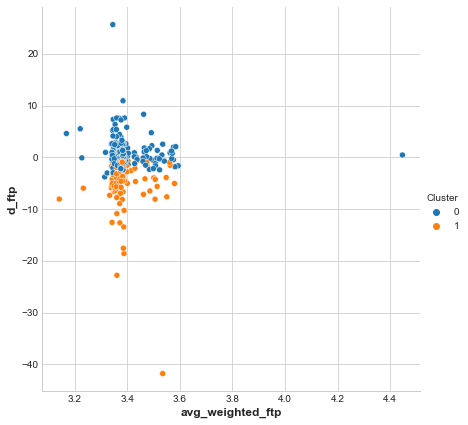

In [112]:
sns.relplot(
    x="avg_weighted_ftp", y="d_ftp", hue="Cluster", data=X, height=6,
);

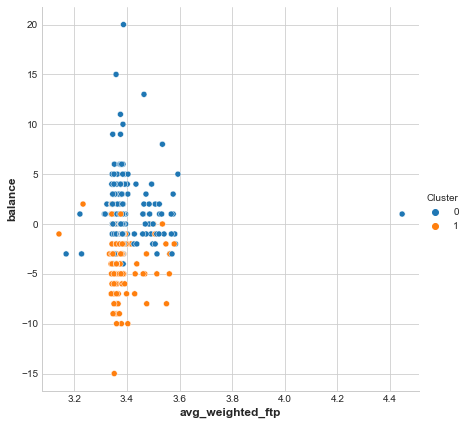

In [113]:
sns.relplot(
    x="avg_weighted_ftp", y="balance", hue="Cluster", data=X, height=6,
);

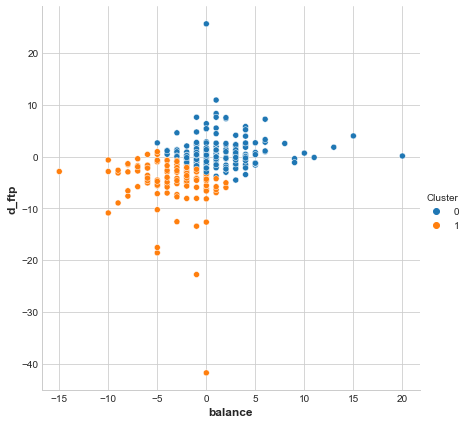

In [114]:
sns.relplot(
    x="balance", y="d_ftp", hue="Cluster", data=X, height=6,
);

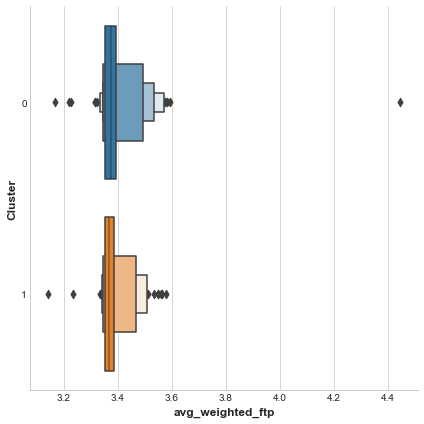

In [115]:
X["avg_weighted_ftp"] = clasterizeDF["avg_weighted_ftp"]
sns.catplot(x="avg_weighted_ftp", y="Cluster", data=X, kind="boxen", height=6);

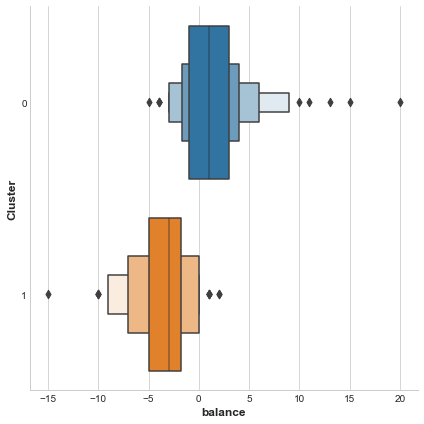

In [116]:
X["balance"] = clasterizeDF["balance"]
sns.catplot(x="balance", y="Cluster", data=X, kind="boxen", height=6);

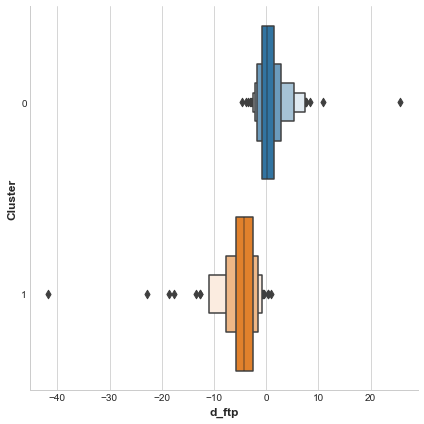

In [117]:
X["d_ftp"] = clasterizeDF["d_ftp"]
sns.catplot(x="d_ftp", y="Cluster", data=X, kind="boxen", height=6);

### 4 clusters

In [138]:
# Create cluster feature
kmeans = KMeans(n_clusters=4)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

avg_weighted_ftp  balance      d_ftp  \
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000        1   0.443333   
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692        8   2.533333   
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692        0 -41.800000   
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257        1   8.312500   
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201        1  -3.800000   

                                     Cluster  
be3b662e-6fda-4c4f-85f8-812a364657f7       2  
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7       1  
939eabb2-f1e4-4bce-8281-2baf58a8f772       3  
4727f484-f08d-48cd-b680-e3625aaa5d50       1  
810e205d-4e6c-4473-a5c4-a8b7568da315       2

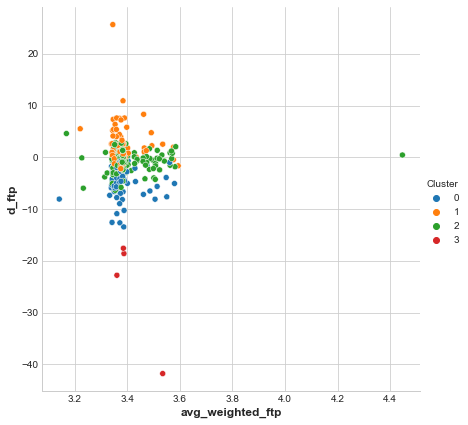

In [139]:
sns.relplot(
    x="avg_weighted_ftp", y="d_ftp", hue="Cluster", data=X, height=6,
);

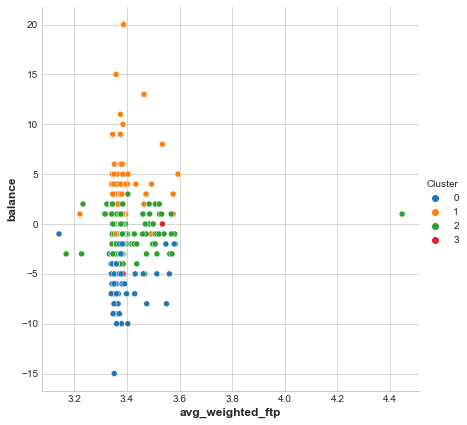

In [140]:
sns.relplot(
    x="avg_weighted_ftp", y="balance", hue="Cluster", data=X, height=6,
);

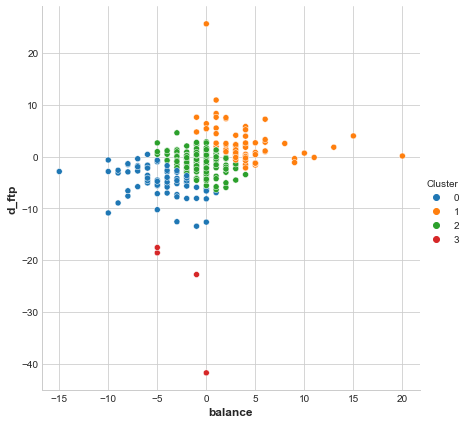

In [141]:
sns.relplot(
    x="balance", y="d_ftp", hue="Cluster", data=X, height=6,
);

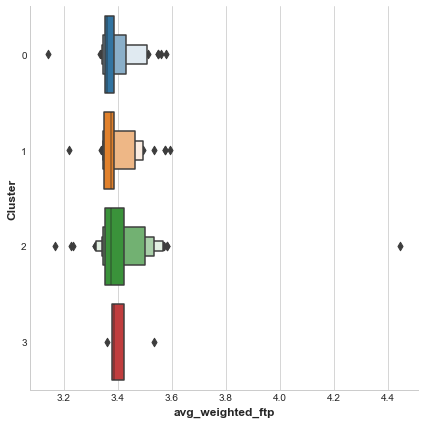

In [142]:
X["avg_weighted_ftp"] = clasterizeDF["avg_weighted_ftp"]
sns.catplot(x="avg_weighted_ftp", y="Cluster", data=X, kind="boxen", height=6);

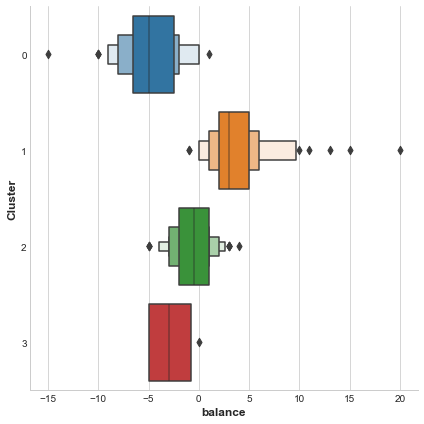

In [143]:
X["balance"] = clasterizeDF["balance"]
sns.catplot(x="balance", y="Cluster", data=X, kind="boxen", height=6);

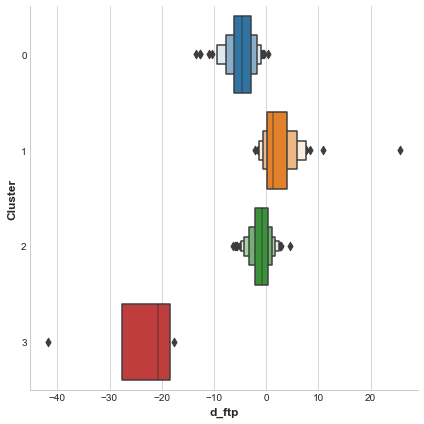

In [144]:
X["d_ftp"] = clasterizeDF["d_ftp"]
sns.catplot(x="d_ftp", y="Cluster", data=X, kind="boxen", height=6);

### 6 clusters

In [145]:
# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

avg_weighted_ftp  balance      d_ftp  \
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000        1   0.443333   
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692        8   2.533333   
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692        0 -41.800000   
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257        1   8.312500   
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201        1  -3.800000   

                                     Cluster  
be3b662e-6fda-4c4f-85f8-812a364657f7       5  
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7       0  
939eabb2-f1e4-4bce-8281-2baf58a8f772       2  
4727f484-f08d-48cd-b680-e3625aaa5d50       4  
810e205d-4e6c-4473-a5c4-a8b7568da315       3

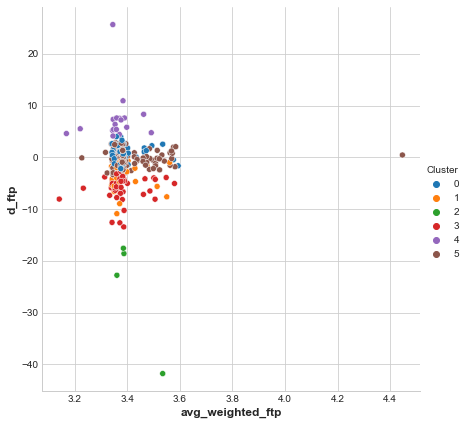

In [146]:
sns.relplot(
    x="avg_weighted_ftp", y="d_ftp", hue="Cluster", data=X, height=6,
);

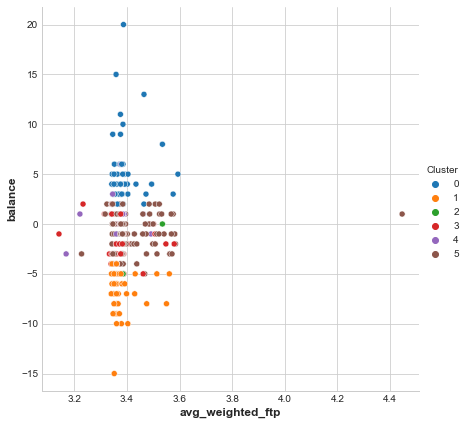

In [147]:
sns.relplot(
    x="avg_weighted_ftp", y="balance", hue="Cluster", data=X, height=6,
);

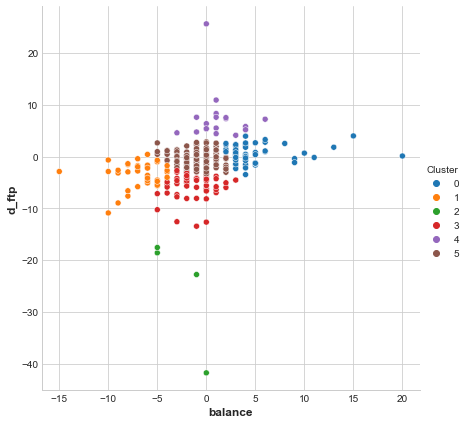

In [148]:
sns.relplot(
    x="balance", y="d_ftp", hue="Cluster", data=X, height=6,
);

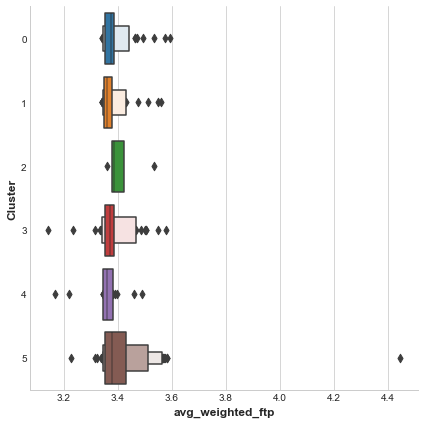

In [149]:
X["avg_weighted_ftp"] = clasterizeDF["avg_weighted_ftp"]
sns.catplot(x="avg_weighted_ftp", y="Cluster", data=X, kind="boxen", height=6);

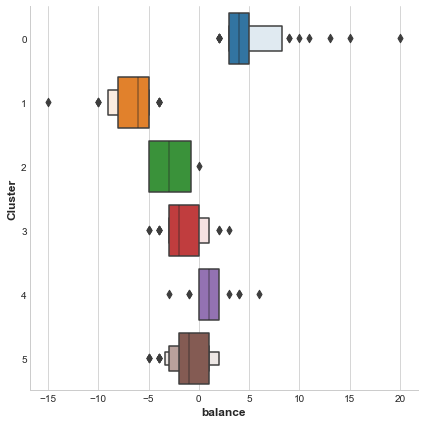

In [150]:
X["balance"] = clasterizeDF["balance"]
sns.catplot(x="balance", y="Cluster", data=X, kind="boxen", height=6);

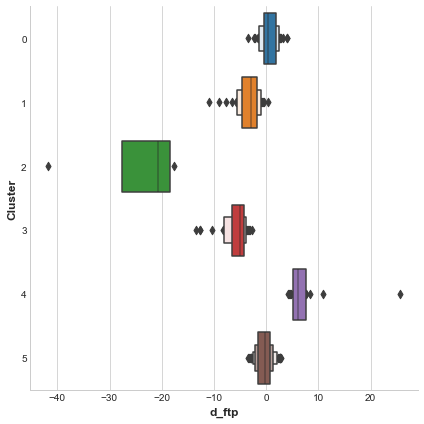

In [151]:
X["d_ftp"] = clasterizeDF["d_ftp"]
sns.catplot(x="d_ftp", y="Cluster", data=X, kind="boxen", height=6);

## 2nd clusterization - (avg_weighted_ftp&d_ftp)

In [134]:
X = clasterizeDF.loc[:, ['avg_weighted_ftp', 'd_ftp']]
X.head()

avg_weighted_ftp      d_ftp
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000   0.443333
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692   2.533333
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692 -41.800000
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257   8.312500
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201  -3.800000

In [119]:
# Create cluster feature
kmeans = KMeans(n_clusters=2)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

avg_weighted_ftp      d_ftp Cluster
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000   0.443333       0
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692   2.533333       0
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692 -41.800000       1
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257   8.312500       0
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201  -3.800000       1

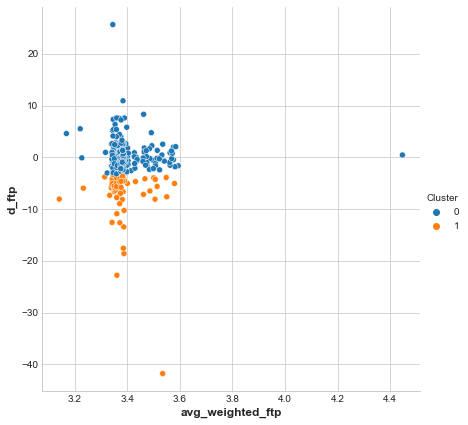

In [120]:
sns.relplot(
    x="avg_weighted_ftp", y="d_ftp", hue="Cluster", data=X, height=6,
);

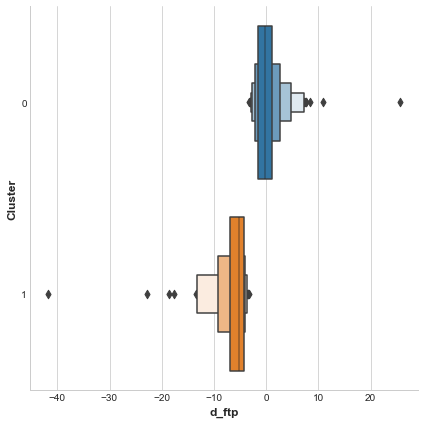

In [121]:
X["d_ftp"] = clasterizeDF["d_ftp"]
sns.catplot(x="d_ftp", y="Cluster", data=X, kind="boxen", height=6);

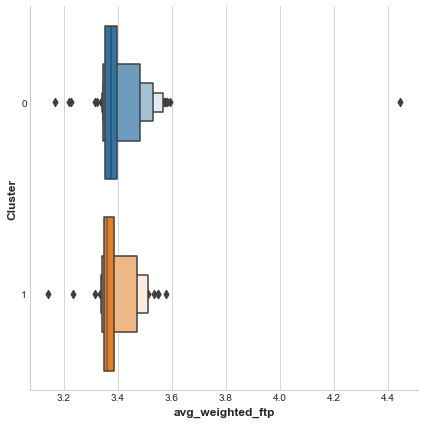

In [122]:
X["avg_weighted_ftp"] = clasterizeDF["avg_weighted_ftp"]
sns.catplot(x="avg_weighted_ftp", y="Cluster", data=X, kind="boxen", height=6);

## 3rd clusterization - (avg_weighted_ftp, balance)

In [135]:
X = clasterizeDF.loc[:, ['avg_weighted_ftp', 'balance']]
X.head()

avg_weighted_ftp  balance
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000        1
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692        8
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692        0
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257        1
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201        1

In [124]:
# Create cluster feature
kmeans = KMeans(n_clusters=2)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

avg_weighted_ftp  balance Cluster
be3b662e-6fda-4c4f-85f8-812a364657f7          4.446000        1       0
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7          3.534692        8       0
939eabb2-f1e4-4bce-8281-2baf58a8f772          3.534692        0       0
4727f484-f08d-48cd-b680-e3625aaa5d50          3.462257        1       0
810e205d-4e6c-4473-a5c4-a8b7568da315          3.314201        1       0

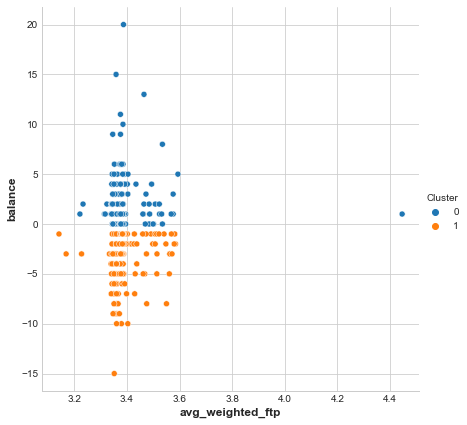

In [125]:
sns.relplot(
    x="avg_weighted_ftp", y="balance", hue="Cluster", data=X, height=6,
);

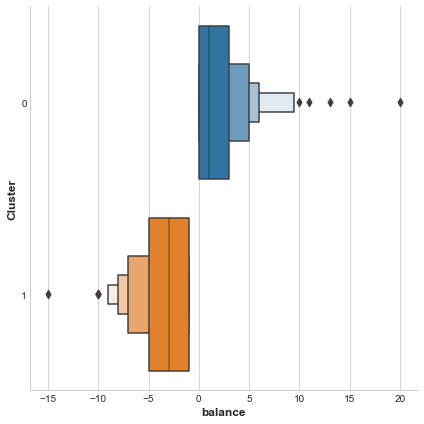

In [126]:
X["balance"] = clasterizeDF["balance"]
sns.catplot(x="balance", y="Cluster", data=X, kind="boxen", height=6);

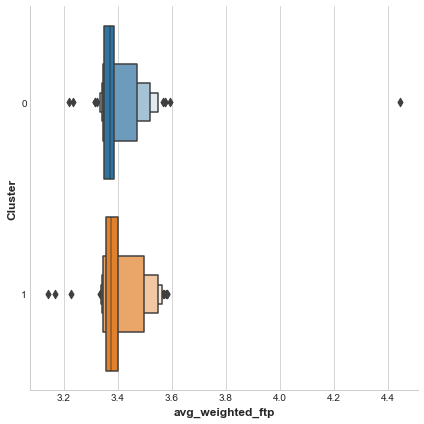

In [127]:
X["avg_weighted_ftp"] = clasterizeDF["avg_weighted_ftp"]
sns.catplot(x="avg_weighted_ftp", y="Cluster", data=X, kind="boxen", height=6);

## 4th clusterization - (d_ftp, balance)

In [136]:
X = clasterizeDF.loc[:, ['d_ftp', 'balance']]
X.head()

d_ftp  balance
be3b662e-6fda-4c4f-85f8-812a364657f7   0.443333        1
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7   2.533333        8
939eabb2-f1e4-4bce-8281-2baf58a8f772 -41.800000        0
4727f484-f08d-48cd-b680-e3625aaa5d50   8.312500        1
810e205d-4e6c-4473-a5c4-a8b7568da315  -3.800000        1

In [129]:
# Create cluster feature
kmeans = KMeans(n_clusters=2)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

d_ftp  balance Cluster
be3b662e-6fda-4c4f-85f8-812a364657f7   0.443333        1       0
705d4ac7-258c-42d6-9ff6-c74b3dbb04c7   2.533333        8       0
939eabb2-f1e4-4bce-8281-2baf58a8f772 -41.800000        0       1
4727f484-f08d-48cd-b680-e3625aaa5d50   8.312500        1       0
810e205d-4e6c-4473-a5c4-a8b7568da315  -3.800000        1       0

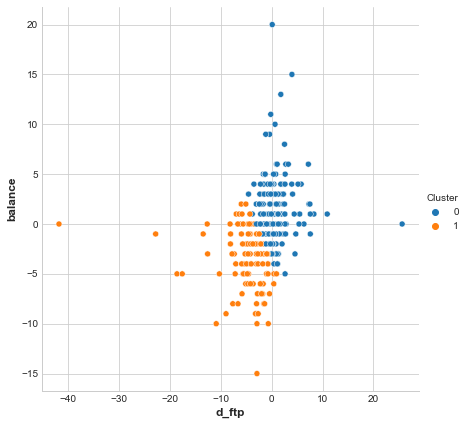

In [130]:
sns.relplot(
    x="d_ftp", y="balance", hue="Cluster", data=X, height=6,
);

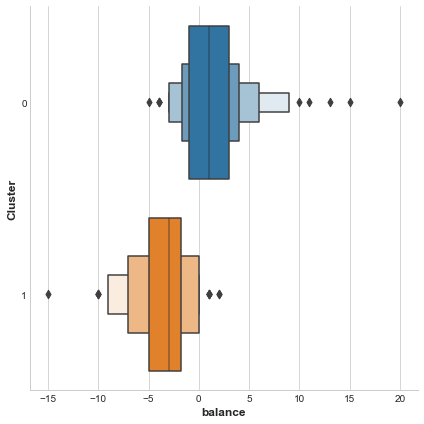

In [131]:
X["balance"] = clasterizeDF["balance"]
sns.catplot(x="balance", y="Cluster", data=X, kind="boxen", height=6);

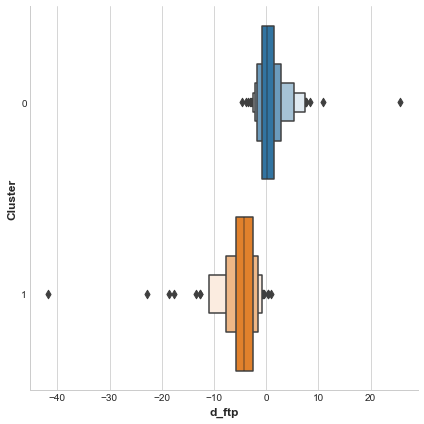

In [132]:
X["d_ftp"] = clasterizeDF["d_ftp"]
sns.catplot(x="d_ftp", y="Cluster", data=X, kind="boxen", height=6);

## ML Model

In [32]:
FinalDF.columns

Index(['athlete', 'weight', 'month', 'ftp', 'weighted_ftp', 'no_activities',
       'duration', 'avg_np', 'time_in_zone1', 'time_in_zone2', 'time_in_zone3',
       'time_in_zone4', 'time_in_zone5', 'time_in_zone6', 'time_in_zone7',
       'tss', 'd_ftp', 'd_ftp_percent', 'd_weighted_ftp',
       'd_weighted_ftp_percent'],
      dtype='object')

In [33]:
#'month'
features = ['weight', 'ftp', 'no_activities', 'duration', 'avg_np', 'time_in_zone1', 'time_in_zone2', 'time_in_zone3', 'time_in_zone4', 'time_in_zone5', 'time_in_zone6', 'time_in_zone7', 'tss']


In [35]:
DF = FinalDF[features]
DF['d_ftp'] = FinalDF['d_ftp']
DF.head(20)

/var/folders/pb/z852ltn51092dt0nsbll7f800000gn/T/ipykernel_13529/1300004179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['d_ftp'] = FinalDF['d_ftp']


weight     ftp  no_activities  duration      avg_np  time_in_zone1  \
0     55.0  238.45             25    392939  149.600000         147356   
1     55.0  241.30             23    325440  178.913043          70736   
2     55.0  247.00             29    385962  174.137931          96111   
3     55.0  242.25             30    402734  168.233333          96742   
4     55.0  253.65             28    375466  169.000000         102148   
5     55.0  255.55             27    408967  179.259259         101061   
6     55.0  234.65             19    282114  173.631579          67110   
7     55.0  257.45             26    328960  188.000000          80678   
8     55.0  247.95             19    146888  185.000000          42118   
9     55.0  242.25             20    210910  206.950000          48557   
10    55.0  236.55             20    249378  178.200000          70716   
11    55.0  239.40             21    218417  183.428571          61095   
12    55.0  247.00             28    200524  196.428571          62946   
13    55.0  239.40             31    264791  193.838710          70109   
14    55.0  245.10             34    403443  203.647059          91178   
15    76.6  191.90             17    104111  138.235294          34436   
16    76.6  207.10             16    148279  159.875000          54956   
17    76.6  209.95             15    102371  139.733333          40216   
18    76.6  211.85             19    160188  134.684211          77203   
19    76.6  226.10             19    164672  151.000000          50149   

    time_in_zone2  time_in_zone3  time_in_zone4  time_in_zone5  time_in_zone6  \
0           45403          35812          27714          16746          12446   
1           49431          46890          43003          22698          10385   
2           64222          53790          37444          19027          10893   
3           64041          62602          43589          19607           9950   
4           77232          54253          32138          14716           6186   
5           62091          54576          31236          14756          10529   
6           31860          26354          27936          20020          17216   
7           60462          42539          30426          17289          10778   
8           29345          20338          12912           8708           6685   
9           30694          32654          20491          13380          12092   
10          40933          36352          23923          12828          13296   
11          41264          34538          19254          13856          12222   
12          32906          27183          18072          13949          10991   
13          35668          29989          20845          15712          18075   
14          51097          53642          36911          19731          19313   
15          37005          12422           7335           3916           3194   
16          35514          20791          12188           6643           5529   
17          23017          12317           7548           4055           3629   
18          30016          15439           9047           5498           6017   
19          35783          24217          19191           8021           3916   

    time_in_zone7          tss  d_ftp  
0            3589  4462.430228   0.00  
1            1858  4846.726559   2.85  
2            2444  5055.405705   5.70  
3            3265  5462.627962  -4.75  
4            1604  4523.859755  11.40  
5            2846  4855.679008   1.90  
6            4913  3923.294958 -20.90  
7            3062  4474.255824  22.80  
8            3092  2311.893636  -9.50  
9            6880  3397.056329  -5.70  
10           4633  3804.408132  -5.70  
11           6465  3650.017900   2.85  
12           5826  3436.486727   7.60  
13           9255  4457.500629  -7.60  
14          12066  6564.100614   5.70  
15           1937  1714.058486   3.80  
16           3589  2577.124962  15.20  
17           2032  1649.878

In [36]:
DF.to_csv('/Users/mateuszbulanda-gorol/Dropbox/Magisterka/ml_df.csv', index=False)

In [38]:
DF = pd.read_csv('ml_df.csv')
DF.head(20)

weight     ftp  no_activities  duration      avg_np  time_in_zone1  \
0     55.0  238.45             25    392939  149.600000         147356   
1     55.0  241.30             23    325440  178.913043          70736   
2     55.0  247.00             29    385962  174.137931          96111   
3     55.0  242.25             30    402734  168.233333          96742   
4     55.0  253.65             28    375466  169.000000         102148   
5     55.0  255.55             27    408967  179.259259         101061   
6     55.0  234.65             19    282114  173.631579          67110   
7     55.0  257.45             26    328960  188.000000          80678   
8     55.0  247.95             19    146888  185.000000          42118   
9     55.0  242.25             20    210910  206.950000          48557   
10    55.0  236.55             20    249378  178.200000          70716   
11    55.0  239.40             21    218417  183.428571          61095   
12    55.0  247.00             28    200524  196.428571          62946   
13    55.0  239.40             31    264791  193.838710          70109   
14    55.0  245.10             34    403443  203.647059          91178   
15    76.6  191.90             17    104111  138.235294          34436   
16    76.6  207.10             16    148279  159.875000          54956   
17    76.6  209.95             15    102371  139.733333          40216   
18    76.6  211.85             19    160188  134.684211          77203   
19    76.6  226.10             19    164672  151.000000          50149   

    time_in_zone2  time_in_zone3  time_in_zone4  time_in_zone5  time_in_zone6  \
0           45403          35812          27714          16746          12446   
1           49431          46890          43003          22698          10385   
2           64222          53790          37444          19027          10893   
3           64041          62602          43589          19607           9950   
4           77232          54253          32138          14716           6186   
5           62091          54576          31236          14756          10529   
6           31860          26354          27936          20020          17216   
7           60462          42539          30426          17289          10778   
8           29345          20338          12912           8708           6685   
9           30694          32654          20491          13380          12092   
10          40933          36352          23923          12828          13296   
11          41264          34538          19254          13856          12222   
12          32906          27183          18072          13949          10991   
13          35668          29989          20845          15712          18075   
14          51097          53642          36911          19731          19313   
15          37005          12422           7335           3916           3194   
16          35514          20791          12188           6643           5529   
17          23017          12317           7548           4055           3629   
18          30016          15439           9047           5498           6017   
19          35783          24217          19191           8021           3916   

    time_in_zone7          tss  d_ftp  
0            3589  4462.430228   0.00  
1            1858  4846.726559   2.85  
2            2444  5055.405705   5.70  
3            3265  5462.627962  -4.75  
4            1604  4523.859755  11.40  
5            2846  4855.679008   1.90  
6            4913  3923.294958 -20.90  
7            3062  4474.255824  22.80  
8            3092  2311.893636  -9.50  
9            6880  3397.056329  -5.70  
10           4633  3804.408132  -5.70  
11           6465  3650.017900   2.85  
12           5826  3436.486727   7.60  
13           9255  4457.500629  -7.60  
14          12066  6564.100614   5.70  
15           1937  1714.058486   3.80  
16           3589  2577.124962  15.20  
17           2032  1649.878

In [39]:
# Create training and validation splits
df_train = DF.sample(frac=0.7, random_state=0)
df_valid = DF.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
#max_ = df_train.max(axis=0)
#min_ = df_train.min(axis=0)
#df_train = (df_train - min_) / (max_ - min_)
#df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('d_ftp', axis=1)
X_valid = df_valid.drop('d_ftp', axis=1)
y_train = df_train['d_ftp']
y_valid = df_valid['d_ftp']

weight     ftp  no_activities  duration      avg_np  time_in_zone1  \
2310    75.0  184.30              7     22548  183.000000           3918   
1916    62.0  170.05             10     56132  156.000000          10321   
3585    66.0  209.95              4     27313  179.750000           1615   
7404    70.0  207.10              3      6942  218.666667           1540   

      time_in_zone2  time_in_zone3  time_in_zone4  time_in_zone5  \
2310           3130           2236           2234           1881   
1916          11253           7681           6823           5304   
3585           6063           8060           5193           2192   
7404            892           1290            722            778   

      time_in_zone6  time_in_zone7          tss  d_ftp  
2310           2290           2012   645.661969 -13.30  
1916           5815           1834  1321.708608  -7.60  
3585           1286            400   549.664412   5.70  
7404           1220            271   197.509871 -35.15

In [40]:
X_train.describe()

weight          ftp  no_activities       duration       avg_np  \
count  5734.000000  5734.000000    5734.000000    5734.000000  5734.000000   
mean     71.722392   238.196015      17.527904  101856.102372   196.404377   
std       9.714184    48.195537      10.693264   65894.137954    36.104905   
min      50.000000    65.550000       1.000000     900.000000    63.558824   
25%      65.000000   205.200000      10.000000   51650.750000   169.723214   
50%      71.000000   238.450000      16.000000   94321.500000   196.320513   
75%      77.000000   269.800000      23.000000  141731.000000   222.476343   
max     109.000000   409.450000      85.000000  539545.000000   383.000000   

       time_in_zone1  time_in_zone2  time_in_zone3  time_in_zone4  \
count    5734.000000    5734.000000    5734.000000    5734.000000   
mean    21638.064702   24081.110394   17545.040112   12903.457970   
std     19328.080423   20803.844212   14655.499643    9345.491862   
min         0.000000       0.000000       0.000000       0.000000   
25%      7466.750000    8803.500000    7635.750000    6679.000000   
50%     17256.500000   19284.500000   14766.000000   11629.000000   
75%     30543.000000   33334.500000   23728.250000   17234.750000   
max    209147.000000  192624.000000  154391.000000  115872.000000   

       time_in_zone5  time_in_zone6  time_in_zone7          tss  
count    5734.000000    5734.000000    5734.000000  5734.000000  
mean     6948.700035    4654.604290    2091.711022  1892.812694  
std      4424.689120    3286.209421    2101.591980  1070.945670  
min         5.000000       0.000000       0.000000    20.467669  
25%      3783.500000    2163.500000     624.000000  1097.742960  
50%      6443.000000    3964.500000    1457.000000  1842.633673  
75%      9311.750000    6575.000000    2841.250000  2582.637866  
max     63719.000000   25731.000000   16424.000000  9423.510583

### Decision Tree Model

In [41]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [42]:
for max_leaf_nodes in [2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,150,200,500,1000]:
    my_mae = get_mae(max_leaf_nodes, X_train, X_valid, y_train, y_valid)
    print(f'Max leaf nodes: {max_leaf_nodes}  \t\t Mean Absolute Error:  {my_mae}')

Max leaf nodes: 2  		 Mean Absolute Error:  14.332704718981114
Max leaf nodes: 3  		 Mean Absolute Error:  14.177162651429049
Max leaf nodes: 4  		 Mean Absolute Error:  14.114122538179636
Max leaf nodes: 5  		 Mean Absolute Error:  14.049905048589977
Max leaf nodes: 6  		 Mean Absolute Error:  14.024378878793412
Max leaf nodes: 7  		 Mean Absolute Error:  14.021199728519989
Max leaf nodes: 8  		 Mean Absolute Error:  14.017666853058824
Max leaf nodes: 9  		 Mean Absolute Error:  14.07141601366929
Max leaf nodes: 10  		 Mean Absolute Error:  14.04734604703188
Max leaf nodes: 20  		 Mean Absolute Error:  14.009778255968127
Max leaf nodes: 30  		 Mean Absolute Error:  14.064520019440018
Max leaf nodes: 40  		 Mean Absolute Error:  14.030293724773276
Max leaf nodes: 50  		 Mean Absolute Error:  14.112943336811322
Max leaf nodes: 60  		 Mean Absolute Error:  14.23903987072724
Max leaf nodes: 70  		 Mean Absolute Error:  14.272815503018116
Max leaf nodes: 80  		 Mean Absolute Error:  14.289

In [43]:
model = DecisionTreeRegressor(max_leaf_nodes=10, random_state=0)
model.fit(X_train, y_train)
dt_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, dt_pred)

In [44]:
mae

14.04734604703188

In [45]:
df_dt = pd.DataFrame()
df_dt['y_valid'] = y_valid
df_dt['dt_pred'] = dt_pred

In [46]:
df_dt

y_valid    dt_pred
0        0.00  -5.414764
7       22.80  -5.414764
19      14.25   0.782275
21       5.70   5.784534
24       0.95   5.784534
25     -12.35  -1.365983
28      -8.55   0.782275
35      -3.80  -1.365983
43      19.95  -7.026724
54     -18.05  -8.768884
56     -33.25  -7.026724
60       9.50  -7.026724
62       9.50  -1.365983
63       8.55  -7.026724
73     -12.35   5.784534
74     -11.40  -7.026724
75      33.25   5.784534
78     -14.25   0.782275
79       8.55   0.782275
81       5.70   0.782275
83     -13.30  -7.026724
89      27.55   0.782275
91      12.35   0.782275
93      -0.95   0.782275
94      16.15   0.782275
99     -27.55   0.926829
100      4.75   0.926829
101     19.95   0.926829
102      3.80   5.784534
103    -37.05 -17.531818
106      5.70  -7.026724
110    -10.45  -1.365983
111    -18.05  -8.768884
112      3.80  -8.768884
115     17.10  -1.365983
116     -8.55  -7.026724
120      0.00  -8.768884
123     -4.75  -1.365983
126      6.65  -8.768884
127    -24.70  -7.026724
128     16.15  -8.768884
129     17.10  -7.026724
131    -22.80  -8.768884
136     21.85   0.782275
139     18.05   0.782275
146     10.45   0.782275
150     16.15   0.782275
151     13.30  -5.414764
153      2.85   0.782275
155     -1.90  -5.414764
160     47.50   0.926829
164    -55.10  -6.094615
165     -7.60   5.784534
168     14.25   0.782275
171      0.95   5.784534
174     -6.65   5.784534
178     10.45  -8.768884
180      9.50  -8.768884
181    -23.75  -1.365983
183     31.35   0.782275
184    -44.65   0.782275
186     -8.55   0.782275
193     25.65   0.782275
197     18.05   0.782275
198    -25.65   0.782275
199      2.85  -6.094615
201      6.65   5.784534
205     22.80   0.782275
207    -12.35  -5.414764
208     22.80  -5.414764
209    -29.45  -5.414764
212      6.65  -5.414764
213    -17.10  -7.026724
216     -1.90  -5.414764
222    -10.45   0.926829
225    -40.85  -7.026724
236     -2.85  -5.414764
237     18.05  -5.414764
239    -36.10  -5.414764
243     27.55   0.926829
250     29.45   0.926829
255     -5.70   0.926829
256    -15.20  -5.414764
262    -73.15   0.782275
266    -14.25   0.782275
267     33.25   0.782275
270     16.15  -7.026724
275      0.00  -5.414764
279     14.25  -7.026724
280     -5.70  -7.026724
281     11.40  -7.026724
284      6.65  -5.414764
292     35.15  -7.026724
293    -15.20  -7.026724
301    -10.45  -7.026724
307    -11.40   0.782275
309     13.30  -7.026724
310      7.60   0.926829
312      6.65  -5.414764
315     -4.75  -5.414764
319     -8.55   0.782275
324    -21.85  -7.026724
327     -6.65   0.926829
329     -2.85  -5.414764
334     20.90  -7.026724
335    -30.40  -7.026724
337     12.35  -5.414764
339      2.85  -5.414764
343      5.70  -5.414764
350      0.95  -5.414764
362     16.15  -5.414764
363    -18.05  -5.414764
367    -32.30  -7.026724
370     12.35  -5.414764
372    -29.45  -5.414764
373     28.50  -5.414764
374      2.85  -5.414764
375     -3.80  -5.414764
377      1.90  -5.414764
387    -24.70  -5.414764
395     -1.90  -7.026724
397    -15.20  -7.026724
400      1.90  -1.365983
403     19.95   0.782275
404    -13.30  -5.414764
407     13.30   5.784534
412    -35.15  -1.365983
416     17.10   5.784534
417     23.75   0.782275
423    -48.45  -8.768884
424      8.55   5.784534
430      5.70   5.784534
431      9.50  -8.768884
432    -27.55  -8.768884
433      7.60   5.784534
434     19.00   0.782275
437    -10.45   0.782275
445     -6.65   0.782275
447    -10.45  15.122449
448     11.40  15.122449
449     -4.75  15.122449
460      3.80  -7.026724
469     -8.55   0.782275
484     -0.95  -1.365983
490    -25.65  -7.026724
492     19.00  -5.414764
494    -13.30  -5.414764
497     14.25  -8.768884
504     19.00  -5.414764
505     24.70   0.782275
508     -3.80  -5.414764
510     -0.95  -7.026724
511     -3.80  -7.026724
512     -5.70   0.782275
513    -39.90  -7.026724
523     -2.85  -5.414764
525    -22.80  -5.414764
537     -0.95  -6.094615
542     26.60   0.782275
544   

### Random Forest Model

In [47]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, y_train)
rf_preds = forest_model.predict(X_valid)
mean_absolute_error(y_valid, rf_preds)

13.649644833197724

In [48]:
df_rf = pd.DataFrame()
df_rf['y_valid'] = y_valid
df_rf['rf_preds'] = rf_preds

In [49]:
df_rf

y_valid      rf_preds
0        0.00 -8.920500e+00
7       22.80 -3.287000e+00
19      14.25  1.548500e+00
21       5.70  6.355500e+00
24       0.95  1.292000e+00
25     -12.35 -5.320000e-01
28      -8.55  5.880500e+00
35      -3.80 -3.116000e+00
43      19.95  1.367050e+01
54     -18.05 -2.166000e+01
56     -33.25 -5.320000e+00
60       9.50 -5.082500e+00
62       9.50 -1.083000e+00
63       8.55  4.835500e+00
73     -12.35  4.028000e+00
74     -11.40 -7.438500e+00
75      33.25  8.369500e+00
78     -14.25 -2.593500e+00
79       8.55  8.227000e+00
81       5.70  5.225000e+00
83     -13.30 -4.370000e-01
89      27.55 -8.835000e-01
91      12.35 -4.237000e+00
93      -0.95 -2.270500e+00
94      16.15 -2.650500e+00
99     -27.55  1.197000e+00
100      4.75 -1.520000e+00
101     19.95 -2.356000e+00
102      3.80  4.541000e+00
103    -37.05 -1.057350e+01
106      5.70 -1.121950e+01
110    -10.45 -7.866000e+00
111    -18.05 -2.037750e+01
112      3.80 -7.296000e+00
115     17.10 -4.294000e+00
116     -8.55 -2.527000e+00
120      0.00 -1.132400e+01
123     -4.75 -7.058500e+00
126      6.65 -1.548500e+00
127    -24.70 -1.707150e+01
128     16.15 -3.420000e+00
129     17.10 -9.015500e+00
131    -22.80 -7.999000e+00
136     21.85  1.102000e+00
139     18.05  1.843000e+00
146     10.45 -5.025500e+00
150     16.15  4.398500e+00
151     13.30 -4.949500e+00
153      2.85 -1.786000e+00
155     -1.90 -6.754500e+00
160     47.50 -1.273000e+00
164    -55.10 -2.071000e+00
165     -7.60 -2.346500e+00
168     14.25 -1.751800e+01
171      0.95  4.028000e+00
174     -6.65  1.542800e+01
178     10.45 -1.709050e+01
180      9.50 -7.961000e+00
181    -23.75 -6.184500e+00
183     31.35  2.755000e+00
184    -44.65  3.106500e+00
186     -8.55 -9.965500e+00
193     25.65  2.413000e+00
197     18.05 -9.842000e+00
198    -25.65 -2.346500e+00
199      2.85 -3.059000e+00
201      6.65 -6.298500e+00
205     22.80 -5.044500e+00
207    -12.35 -7.372000e+00
208     22.80 -1.596000e+00
209    -29.45 -9.148500e+00
212      6.65 -6.887500e+00
213    -17.10 -6.916000e+00
216     -1.90 -4.284500e+00
222    -10.45  1.425000e+00
225    -40.85 -6.156000e+00
236     -2.85 -1.269200e+01
237     18.05 -7.220000e+00
239    -36.10 -3.705000e+00
243     27.55  1.168500e+00
250     29.45  5.396000e+00
255     -5.70  6.080000e-01
256    -15.20 -1.281550e+01
262    -73.15 -3.524500e+00
266    -14.25  1.054500e+00
267     33.25  5.823500e+00
270     16.15 -1.247350e+01
275      0.00 -1.729000e+00
279     14.25 -6.697500e+00
280     -5.70 -1.132400e+01
281     11.40 -1.349000e+00
284      6.65 -6.944500e+00
292     35.15 -3.239500e+00
293    -15.20 -4.655000e-01
301    -10.45 -4.189500e+00
307    -11.40 -5.396000e+00
309     13.30 -2.280000e-01
310      7.60  1.425000e-01
312      6.65 -7.115500e+00
315     -4.75 -6.868500e+00
319     -8.55  5.481500e+00
324    -21.85 -5.443500e+00
327     -6.65  4.655000e+00
329     -2.85 -1.501000e+00
334     20.90 -7.229500e+00
335    -30.40 -6.308000e+00
337     12.35 -3.068500e+00
339      2.85  5.415000e-01
343      5.70 -4.864000e+00
350      0.95 -6.745000e-01
362     16.15  5.472000e+00
363    -18.05 -1.130500e+00
367    -32.30 -1.022200e+01
370     12.35 -6.621500e+00
372    -29.45 -1.147600e+01
373     28.50  2.660000e+00
374      2.85  1.862000e+00
375     -3.80 -2.660000e-01
377      1.90  1.729000e+00
387    -24.70 -5.301000e+00
395     -1.90  2.707500e+00
397    -15.20  3.211000e+00
400      1.90 -5.035000e+00
403     19.95  4.940000e-01
404    -13.30 -2.593500e+00
407     13.30  4.218000e+00
412    -35.15  4.845000e-01
416     17.10  2.071000e+00
417     23.75  6.754500e+00
423    -48.45 -6.583500e+00
424      8.55  2.954500e+00
430      5.70 -1.330000e+00
431      9.50 -5.918500e+00
432    -27.55 -2.926000e+00
433      7.60 -2.441500e+00
434     19.00  2.099500e+00
437    -10.45 -1.757500e+00
445     -6.65 -6.213000e+00
447    -10.45  9.538000e+00
448     11.40  1.988350e+01
449     -4.75  1.020300e+01
460      3.80 -1.957000e+00
46

### Extreme Gradient Boosting Model

In [50]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_valid)
mean_absolute_error(y_valid, xgb_pred)

/Users/mateuszbulanda-gorol/opt/anaconda3/envs/tf/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


14.409280187549241

In [51]:
def xgb_mae(n_estimators, train_X, val_X, train_y, val_y):
    xgb_model = XGBRegressor(n_estimators=n_estimators, learning_rate=0.05, n_jobs=4)
    xgb_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(val_X,val_y)], varbose=False)
    xgb_pred = xgb_model.predict(val_X)
    xgb_mae = mean_absolute_error(xgb_pred, val_y)
    return xgb_mae

In [52]:
for n_estimators in [100,200,300,400,500,600,700,800,900,1000]:
    xgb_mae = get_mae(n_estimators, X_train, X_valid, y_train, y_valid)
    print(f'No estimators: {n_estimators}  \t\t Mean Absolute Error:  {xgb_mae}')

No estimators: 100  		 Mean Absolute Error:  14.56947573554048
No estimators: 200  		 Mean Absolute Error:  15.11977838151883
No estimators: 300  		 Mean Absolute Error:  15.885569092092071
No estimators: 400  		 Mean Absolute Error:  16.28809131426469
No estimators: 500  		 Mean Absolute Error:  16.7493371896262
No estimators: 600  		 Mean Absolute Error:  17.111414883349504
No estimators: 700  		 Mean Absolute Error:  17.373130283774138
No estimators: 800  		 Mean Absolute Error:  17.507581023192156
No estimators: 900  		 Mean Absolute Error:  17.851925174750523
No estimators: 1000  		 Mean Absolute Error:  18.093729897974285


### Sequential Model

In [53]:
print(X_train.shape)

(5734, 13)


In [54]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=30, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [95]:
model = keras.Sequential([
    layers.Dense(4096, activation='relu', input_shape=[13]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

In [96]:
model.compile(
    optimizer='adam',
    loss='mae',
)

In [97]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

Minimum validation loss: 13.724555015563965


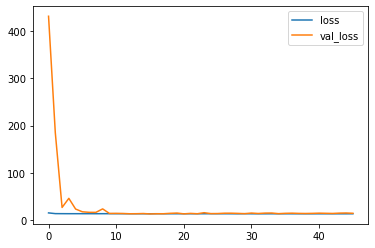

In [98]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [99]:
history_df.head(30)

loss    val_loss
0   15.858897  430.631775
1   14.351037  184.929306
2   14.249686   27.359180
3   14.193444   46.567165
4   14.199407   24.001972
5   14.183762   18.206520
6   14.180821   17.082005
7   14.122515   16.990786
8   14.204940   24.325344
9   14.174973   14.729086
10  14.129981   14.865921
11  14.123948   14.591799
12  14.049239   14.067954
13  14.056865   14.164210
14  14.085133   14.534400
15  14.026685   13.724555
16  14.151833   14.050894
17  14.047322   14.112833
18  14.051112   14.993871
19  14.070745   15.510777
20  14.031031   13.883151
21  14.064525   14.828308
22  14.014455   14.092231
23  14.075336   16.283464
24  14.107162   14.374485
25  14.049542   14.521556
26  14.056997   15.200895
27  14.015240   15.248999
28  13.954974   14.837137
29  14.136035   14.280449

In [100]:
seq_pred = model.predict(X_valid)
seqDF = pd.DataFrame(y_valid)
seqDF['seq_pred'] = seq_pred
seqDF.head(30)

77/77 [==============================] - 9s 109ms/step


d_ftp  seq_pred
0     0.00  2.109999
7    22.80 -0.868964
19   14.25  9.323878
21    5.70  7.362654
24    0.95  4.980586
25  -12.35  2.155059
28   -8.55  9.949760
35   -3.80 -2.522422
43   19.95 -2.310605
54  -18.05 -2.131562
56  -33.25 -6.754113
60    9.50 -4.028938
62    9.50 -2.578275
63    8.55  4.882921
73  -12.35  4.121128
74  -11.40  1.772814
75   33.25  8.043691
78  -14.25  2.594090
79    8.55  4.425062
81    5.70  3.426460
83  -13.30 -2.503505
89   27.55  2.061615
91   12.35  2.047974
93   -0.95  3.780896
94   16.15  3.785845
99  -27.55 -1.676932
100   4.75  1.312590
101  19.95  1.789849
102   3.80  3.883061
103 -37.05 -3.785297